In [1]:
%matplotlib inline

import numpy as np
import copy


import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early, cfg_policy_evaluation_maxiter
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomCartPole-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

policy_evaluation_maxiter = cfg_policy_evaluation_maxiter
print("policy_evaluation_maxiter",policy_evaluation_maxiter)
print("alpha",alpha)
print("seed",seed)
print(datetime.datetime.now())

policy_evaluation_maxiter 5
alpha 0.1
seed 3
2023-07-29 06:25:31.110596


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



4 1 2


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_cartpole_bamdp_standardvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

dec: h_dim 64
base load ckpt ckpt_basevi_cartpole_unweighted
base load self.initial_belief.data.sum() tensor(-9.7880)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(6.1169)
penalty_target_min tensor(-11.5544) penalty_target_max tensor(5.6463)
train_loss:  -8.043964761543275
valid_loss:  -8.192152389526367
h_min_tilde -11.554436 ell_tilde -8.073602287139895 kappa_tilde 0.0005359920875303314


In [5]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 1.1920928955078125e-06


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



 1 4.140527009963989

 2 3.4818596839904785

 3 3.8330142498016357

 4 3.543402671813965

 5 3.7306623458862305

 6 3.533662796020508

 7 3.762758493423462

 8 3.6255950927734375

 9 3.534914255142212

 10 3.8937904834747314

 11 3.469938278198242

 12 3.549370288848877

 13 3.5106053352355957

 14 3.752413272857666

 15 3.601651430130005

 16 3.3311057090759277

 17 3.386556386947632

 18 3.382535934448242

 19 6.765209913253784

 20 4.643707990646362

 21 3.476918935775757

 22 3.3513295650482178

 23 3.578120231628418

 24 4.012103796005249

 25 3.6286425590515137

 26 3.6410586833953857

 27 3.644754409790039

 28 3.648869276046753

 29 3.6409590244293213

 30 3.5946762561798096

 31 3.563291549682617

 32 3.665337324142456

 33 3.5960311889648438

 34 3.51541805267334

 35 3.6176114082336426

 36 3.618682861328125

 37 3.6865880489349365

 38 3.593489646911621

 39 3.624729633331299

 40 3.6604197025299072

 41 6.359373331069946

 42 6.223220586776733

 43 3.5351014137268066

 44

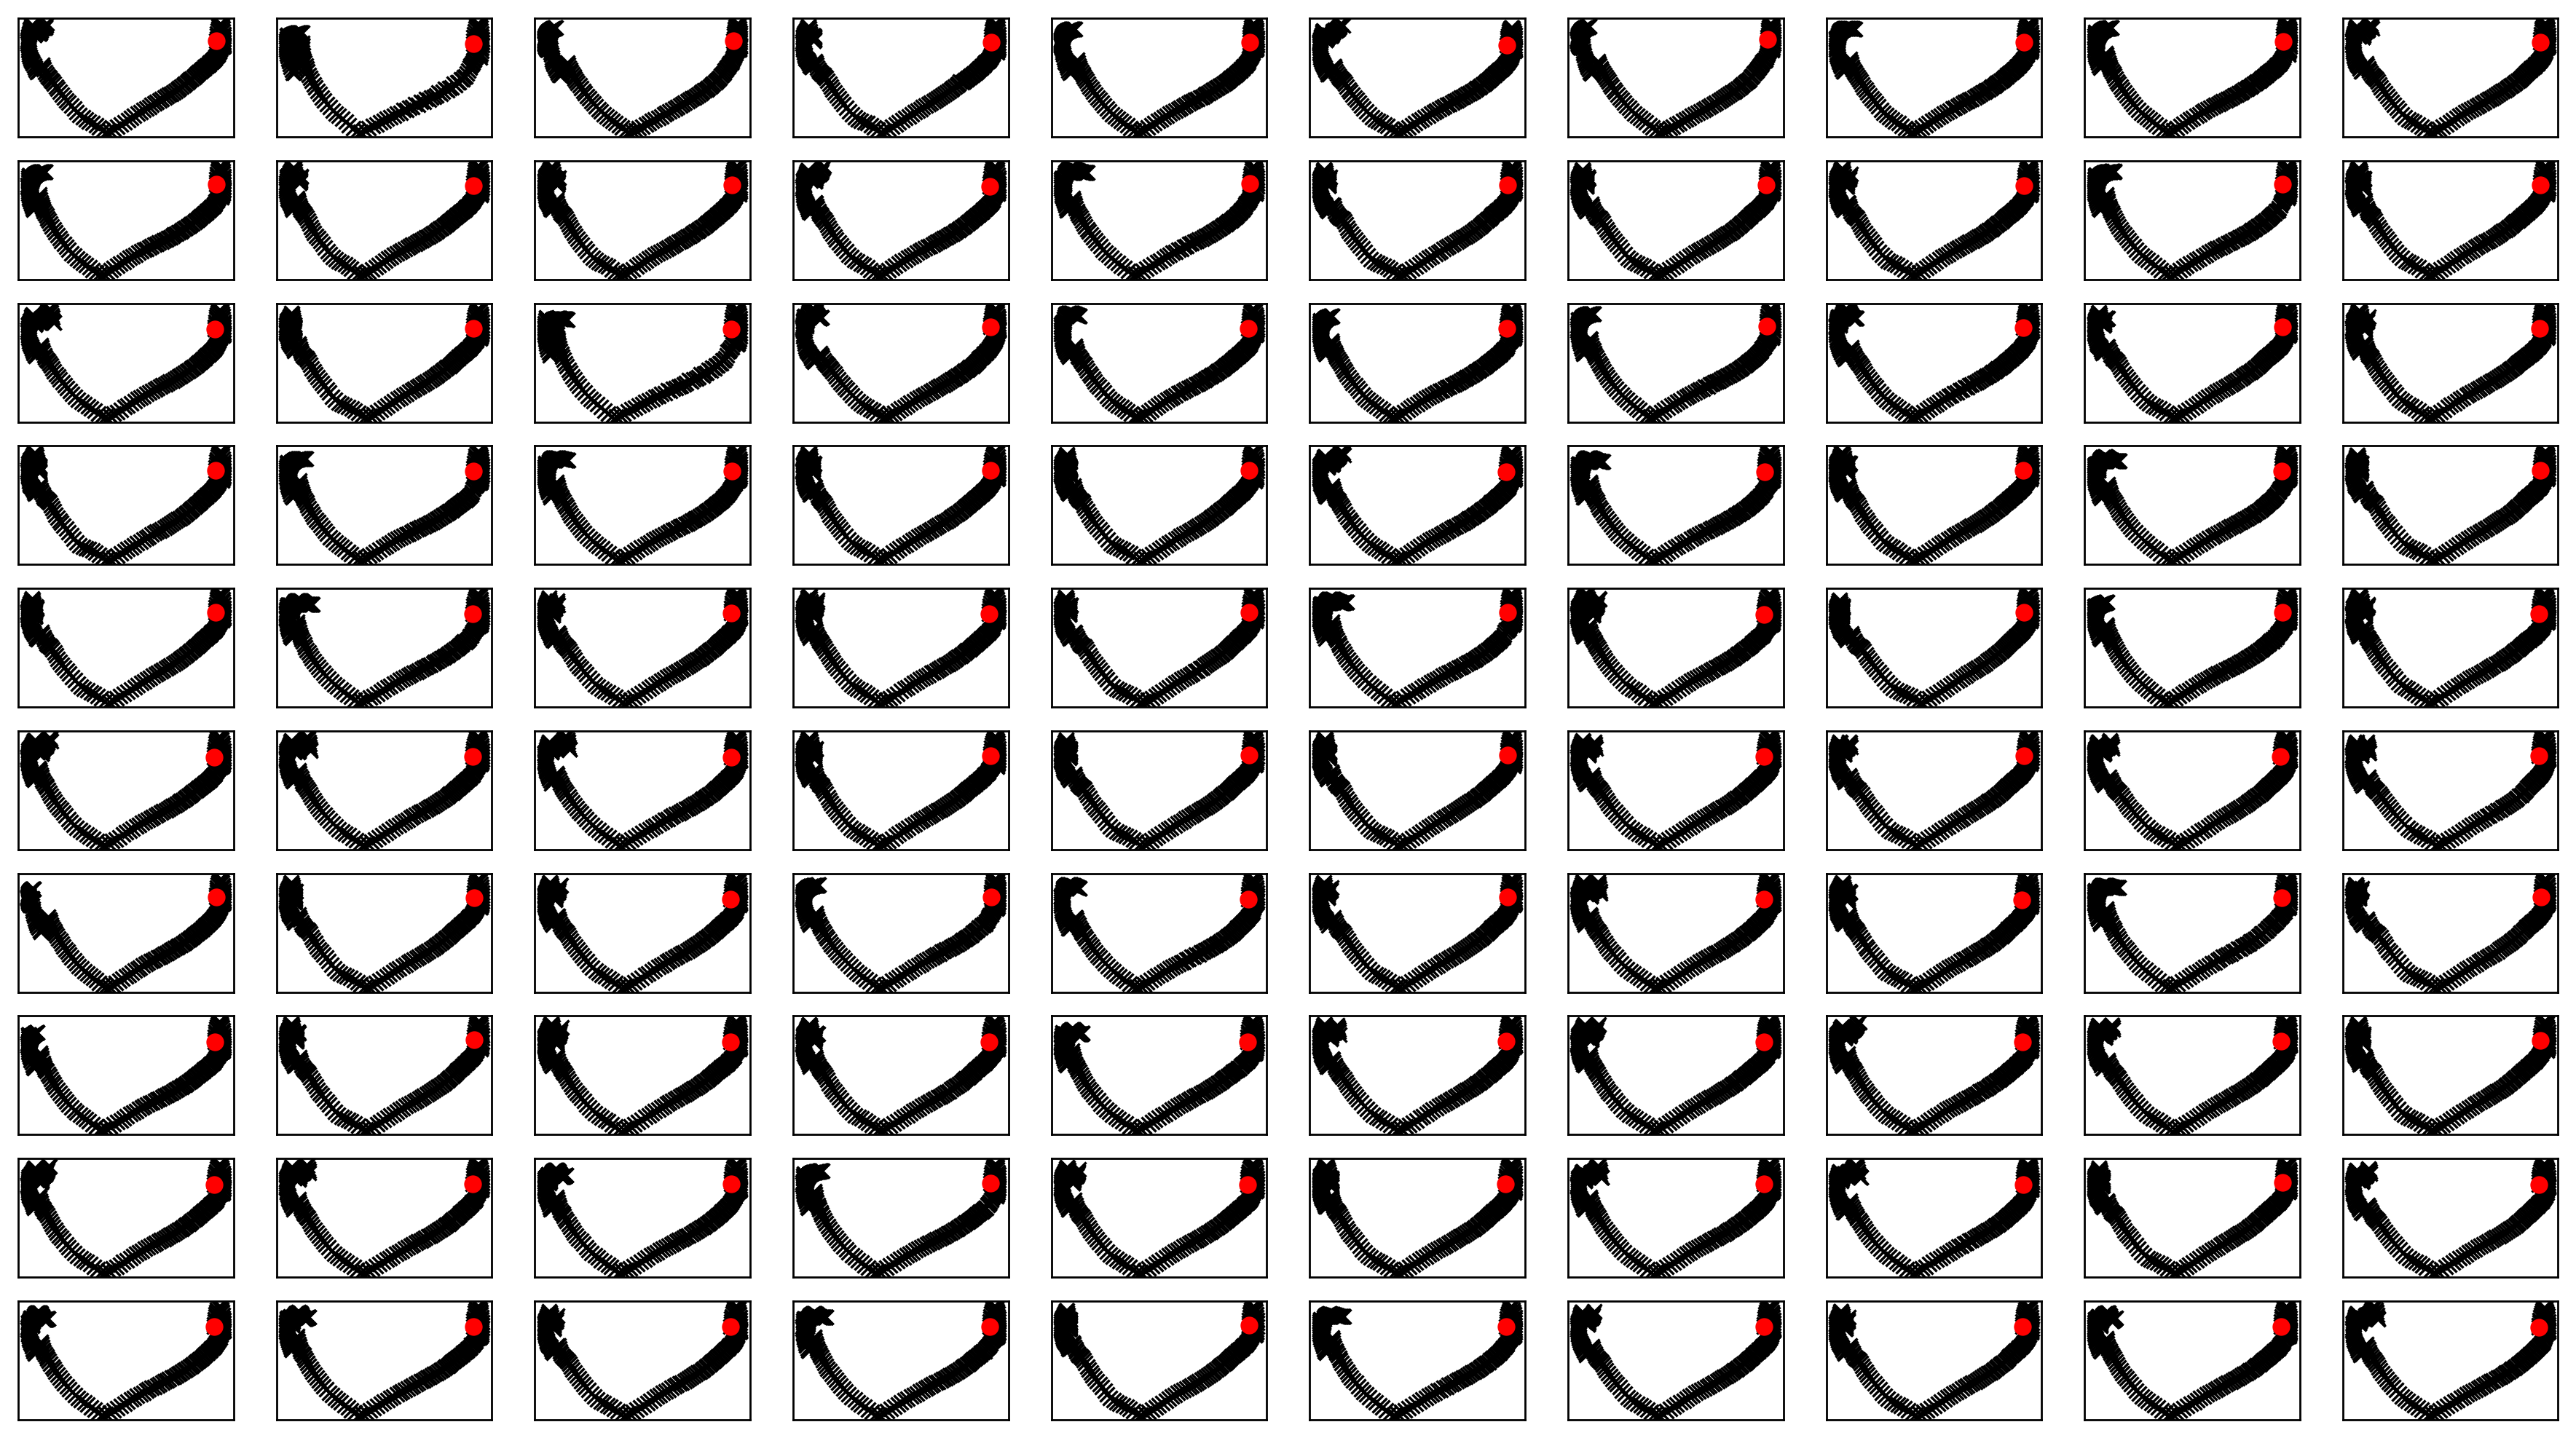

In [6]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

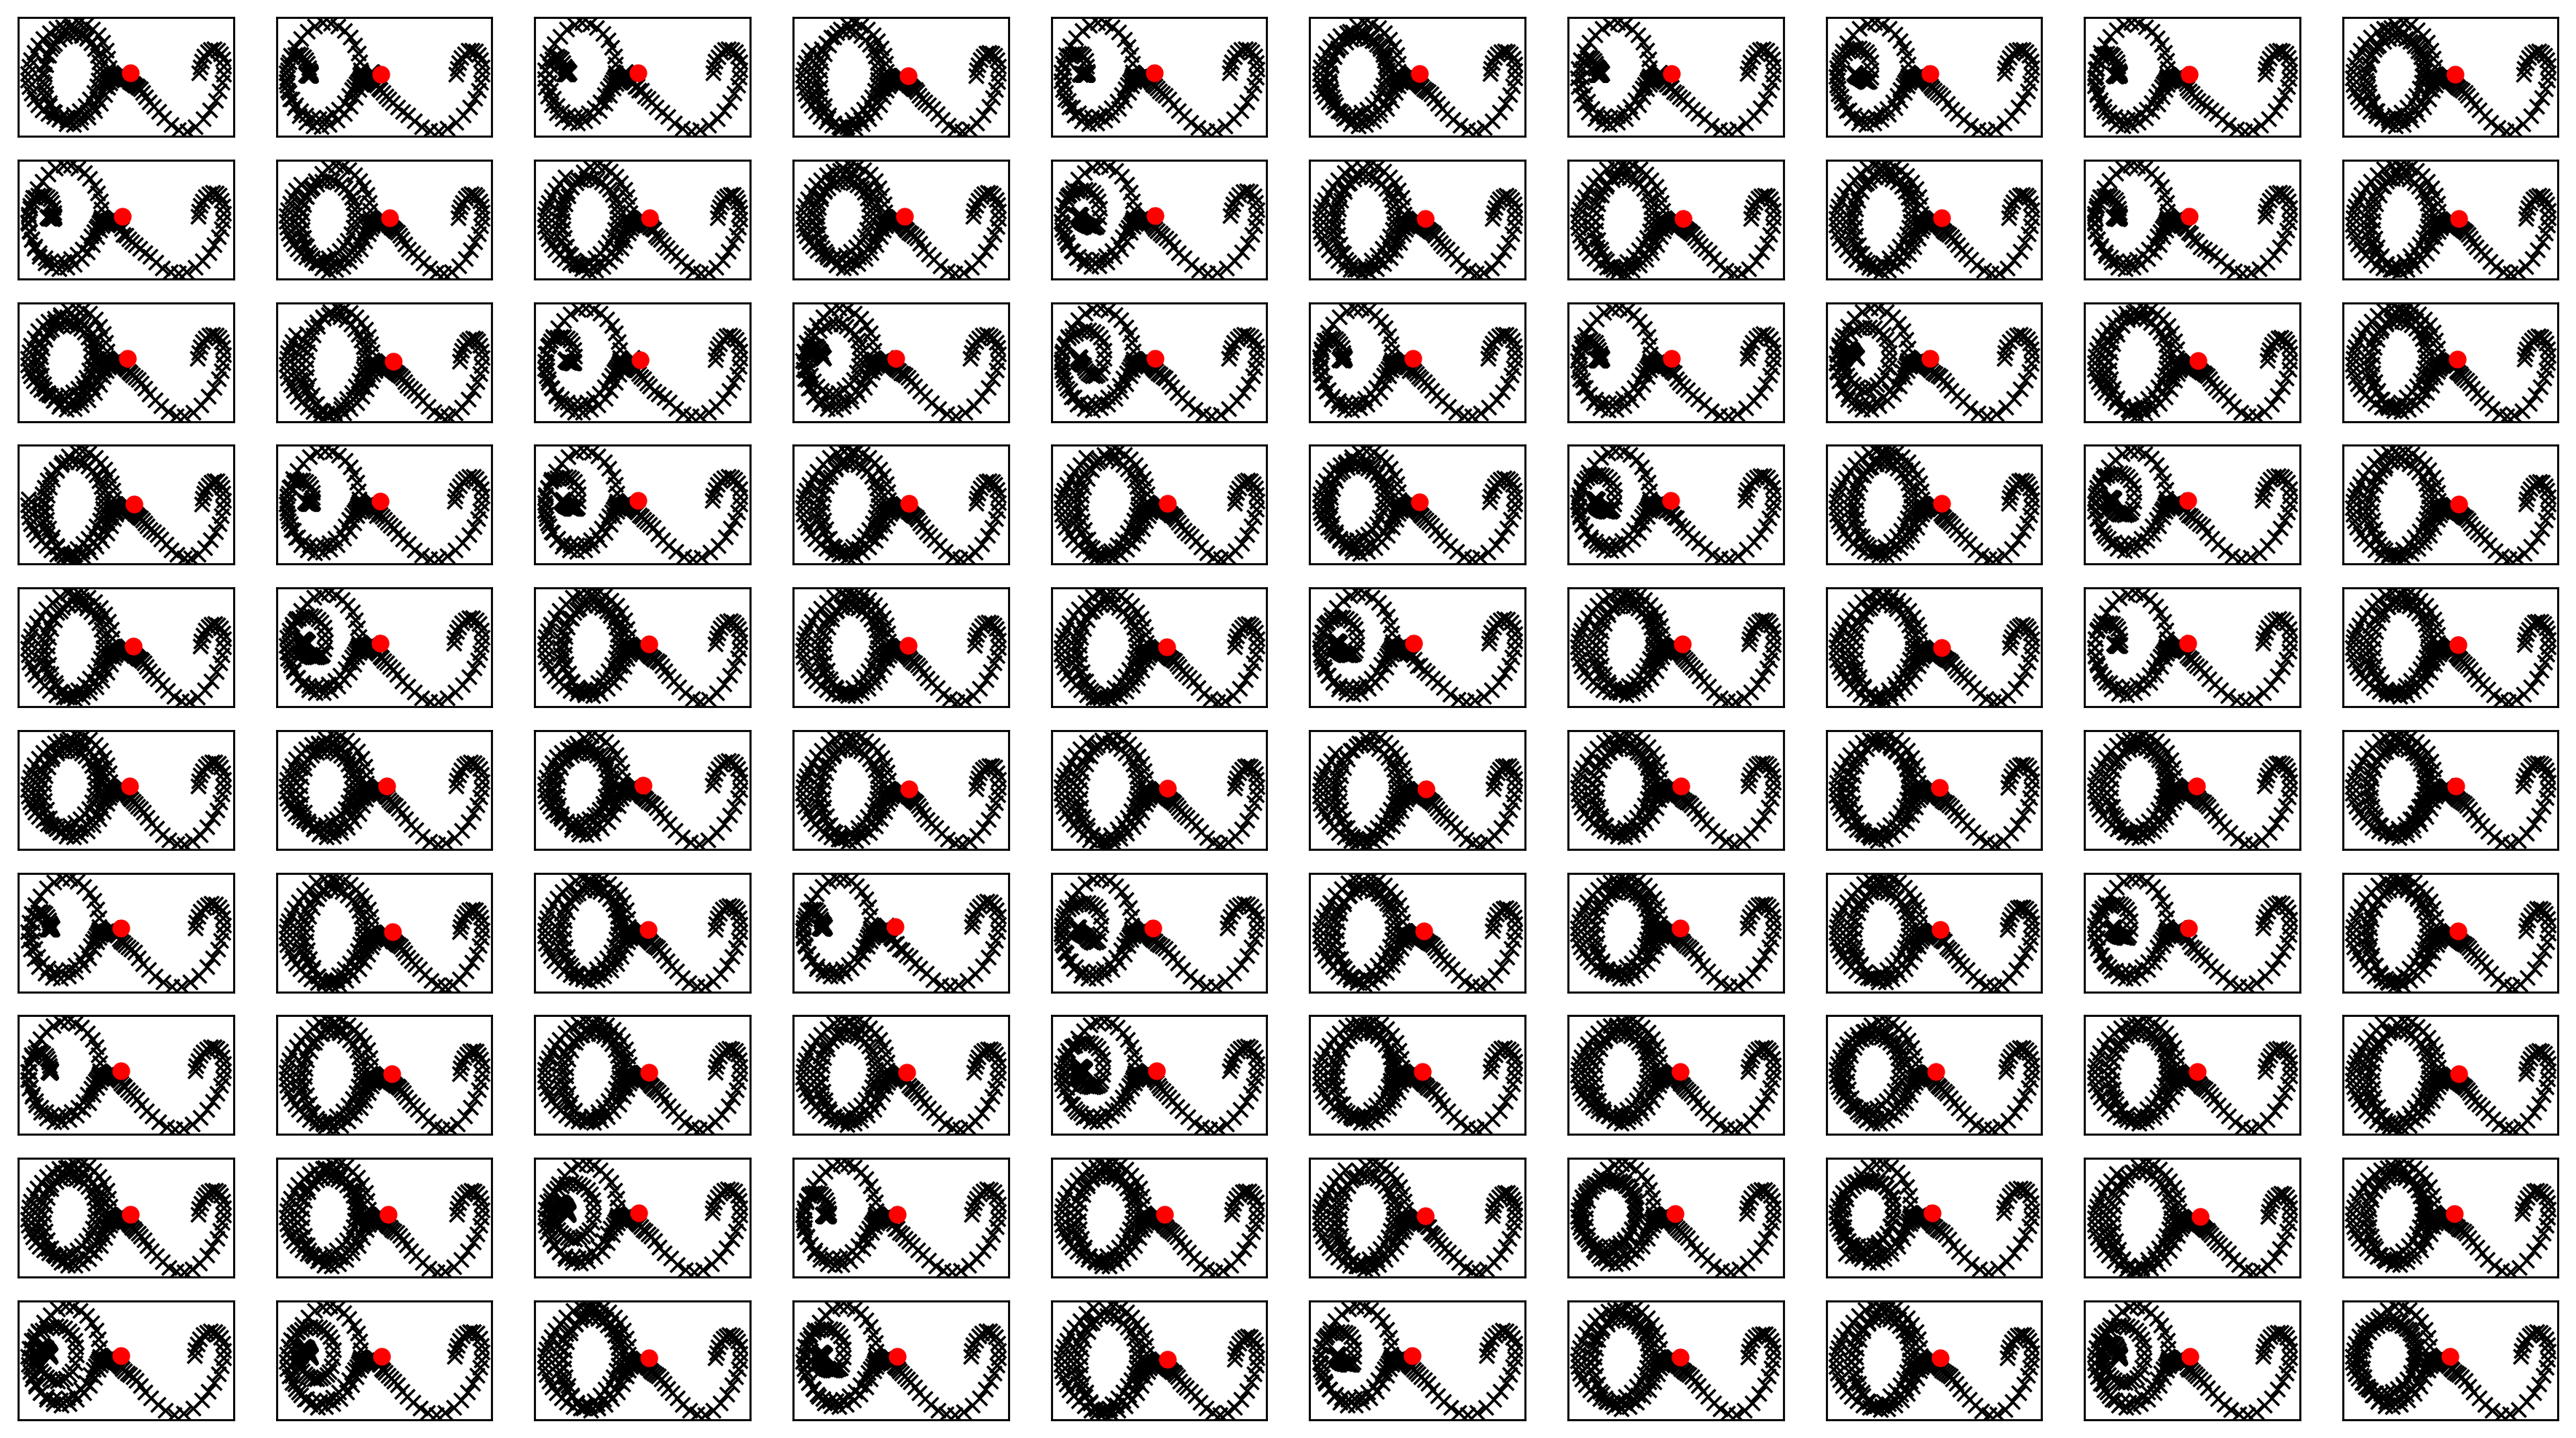

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,2], iwvi.debug_realenv_rolloutdata[i][:,3],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

In [8]:
print(datetime.datetime.now())

2023-07-29 06:32:49.125088


# Iter 1

In [9]:
policy_evaluation_iter=0

In [10]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [11]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.36974  validloss 1.43308±0.00000  bestvalidloss 1.43308  last_update 0
train: iter 1  trainloss 1.23993  validloss 1.31496±0.00000  bestvalidloss 1.31496  last_update 0
train: iter 2  trainloss 1.10842  validloss 1.15885±0.00000  bestvalidloss 1.15885  last_update 0
train: iter 3  trainloss 1.01412  validloss 1.04060±0.00000  bestvalidloss 1.04060  last_update 0
train: iter 4  trainloss 0.94526  validloss 0.96183±0.00000  bestvalidloss 0.96183  last_update 0
train: iter 5  trainloss 0.90192  validloss 0.90175±0.00000  bestvalidloss 0.90175  last_update 0
train: iter 6  trainloss 0.86202  validloss 0.85617±0.00000  bestvalidloss 0.85617  last_update 0
train: iter 7  trainloss 0.82947  validloss 0.80952±0.00000  bestvalidloss 0.80952  last_update 0
train: iter 8  trainloss 0.78323  validloss 0.77861±0.00000  bestvalidloss 0.77861  last_update 0
train: iter 9  trainloss 0.76308  validloss 0.75010±0.00000  bestvalidloss 0.75010  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.42464  validloss 0.42880±0.00000  bestvalidloss 0.42589  last_update 1
train: iter 84  trainloss 0.41779  validloss 0.44311±0.00000  bestvalidloss 0.42589  last_update 2
train: iter 85  trainloss 0.42115  validloss 0.42318±0.00000  bestvalidloss 0.42318  last_update 0
train: iter 86  trainloss 0.41758  validloss 0.42559±0.00000  bestvalidloss 0.42318  last_update 1
train: iter 87  trainloss 0.40772  validloss 0.42179±0.00000  bestvalidloss 0.42179  last_update 0
train: iter 88  trainloss 0.41099  validloss 0.41982±0.00000  bestvalidloss 0.41982  last_update 0
train: iter 89  trainloss 0.41259  validloss 0.43446±0.00000  bestvalidloss 0.41982  last_update 1
train: iter 90  trainloss 0.41108  validloss 0.44016±0.00000  bestvalidloss 0.41982  last_update 2
train: iter 91  trainloss 0.40591  validloss 0.42004±0.00000  bestvalidloss 0.41982  last_update 3
train: iter 92  trainloss 0.41132  validloss 0.43078±0.00000  bestvalidloss 0.41982  last_update 4
train: ite

train: iter 167  trainloss 0.36473  validloss 0.38287±0.00000  bestvalidloss 0.38287  last_update 0
train: iter 168  trainloss 0.35987  validloss 0.38947±0.00000  bestvalidloss 0.38287  last_update 1
train: iter 169  trainloss 0.36372  validloss 0.39777±0.00000  bestvalidloss 0.38287  last_update 2
train: iter 170  trainloss 0.36708  validloss 0.38755±0.00000  bestvalidloss 0.38287  last_update 3
train: iter 171  trainloss 0.36827  validloss 0.38871±0.00000  bestvalidloss 0.38287  last_update 4
train: iter 172  trainloss 0.36391  validloss 0.39078±0.00000  bestvalidloss 0.38287  last_update 5
train: iter 173  trainloss 0.36886  validloss 0.38708±0.00000  bestvalidloss 0.38287  last_update 6
train: iter 174  trainloss 0.36011  validloss 0.38042±0.00000  bestvalidloss 0.38042  last_update 0
train: iter 175  trainloss 0.36199  validloss 0.38923±0.00000  bestvalidloss 0.38042  last_update 1
train: iter 176  trainloss 0.36409  validloss 0.39224±0.00000  bestvalidloss 0.38042  last_update 2


train: iter 249  trainloss 0.33413  validloss 0.37525±0.00000  bestvalidloss 0.36256  last_update 6
train: iter 250  trainloss 0.33471  validloss 0.36499±0.00000  bestvalidloss 0.36256  last_update 7
train: iter 251  trainloss 0.33884  validloss 0.36365±0.00000  bestvalidloss 0.36256  last_update 8
train: iter 252  trainloss 0.34164  validloss 0.36429±0.00000  bestvalidloss 0.36256  last_update 9
train: iter 253  trainloss 0.33170  validloss 0.36725±0.00000  bestvalidloss 0.36256  last_update 10
train: iter 254  trainloss 0.34608  validloss 0.38939±0.00000  bestvalidloss 0.36256  last_update 11
train: iter 255  trainloss 0.33752  validloss 0.36648±0.00000  bestvalidloss 0.36256  last_update 12
train: iter 256  trainloss 0.34210  validloss 0.36667±0.00000  bestvalidloss 0.36256  last_update 13
train: iter 257  trainloss 0.34519  validloss 0.36300±0.00000  bestvalidloss 0.36256  last_update 14
train: iter 258  trainloss 0.34097  validloss 0.41541±0.00000  bestvalidloss 0.36256  last_upda

train: iter 332  trainloss 0.32513  validloss 0.35031±0.00000  bestvalidloss 0.34828  last_update 3
train: iter 333  trainloss 0.31352  validloss 0.35741±0.00000  bestvalidloss 0.34828  last_update 4
train: iter 334  trainloss 0.31658  validloss 0.34954±0.00000  bestvalidloss 0.34828  last_update 5
train: iter 335  trainloss 0.31584  validloss 0.35512±0.00000  bestvalidloss 0.34828  last_update 6
train: iter 336  trainloss 0.31556  validloss 0.35928±0.00000  bestvalidloss 0.34828  last_update 7
train: iter 337  trainloss 0.31164  validloss 0.34672±0.00000  bestvalidloss 0.34672  last_update 0
train: iter 338  trainloss 0.32310  validloss 0.35054±0.00000  bestvalidloss 0.34672  last_update 1
train: iter 339  trainloss 0.31558  validloss 0.37091±0.00000  bestvalidloss 0.34672  last_update 2
train: iter 340  trainloss 0.31310  validloss 0.34811±0.00000  bestvalidloss 0.34672  last_update 3
train: iter 341  trainloss 0.31163  validloss 0.35747±0.00000  bestvalidloss 0.34672  last_update 4


train: iter 414  trainloss 0.29599  validloss 0.36779±0.00000  bestvalidloss 0.33853  last_update 6
train: iter 415  trainloss 0.29913  validloss 0.34138±0.00000  bestvalidloss 0.33853  last_update 7
train: iter 416  trainloss 0.29918  validloss 0.35353±0.00000  bestvalidloss 0.33853  last_update 8
train: iter 417  trainloss 0.30126  validloss 0.34735±0.00000  bestvalidloss 0.33853  last_update 9
train: iter 418  trainloss 0.29909  validloss 0.34017±0.00000  bestvalidloss 0.33853  last_update 10
train: iter 419  trainloss 0.29843  validloss 0.34715±0.00000  bestvalidloss 0.33853  last_update 11
train: iter 420  trainloss 0.30048  validloss 0.33823±0.00000  bestvalidloss 0.33823  last_update 0
train: iter 421  trainloss 0.29792  validloss 0.34006±0.00000  bestvalidloss 0.33823  last_update 1
train: iter 422  trainloss 0.29686  validloss 0.38187±0.00000  bestvalidloss 0.33823  last_update 2
train: iter 423  trainloss 0.29630  validloss 0.34005±0.00000  bestvalidloss 0.33823  last_update 

train: iter 496  trainloss 0.28687  validloss 0.33307±0.00000  bestvalidloss 0.32791  last_update 3
train: iter 497  trainloss 0.28078  validloss 0.33935±0.00000  bestvalidloss 0.32791  last_update 4
train: iter 498  trainloss 0.28516  validloss 0.32920±0.00000  bestvalidloss 0.32791  last_update 5
train: iter 499  trainloss 0.28467  validloss 0.33091±0.00000  bestvalidloss 0.32791  last_update 6
train: iter 500  trainloss 0.28795  validloss 0.33759±0.00000  bestvalidloss 0.32791  last_update 7
train: iter 501  trainloss 0.28136  validloss 0.33133±0.00000  bestvalidloss 0.32791  last_update 8
train: iter 502  trainloss 0.27931  validloss 0.33380±0.00000  bestvalidloss 0.32791  last_update 9
train: iter 503  trainloss 0.28853  validloss 0.33663±0.00000  bestvalidloss 0.32791  last_update 10
train: iter 504  trainloss 0.29361  validloss 0.33320±0.00000  bestvalidloss 0.32791  last_update 11
train: iter 505  trainloss 0.28535  validloss 0.33181±0.00000  bestvalidloss 0.32791  last_update 

train: iter 578  trainloss 0.27048  validloss 0.31794±0.00000  bestvalidloss 0.31725  last_update 4
train: iter 579  trainloss 0.27087  validloss 0.32368±0.00000  bestvalidloss 0.31725  last_update 5
train: iter 580  trainloss 0.27050  validloss 0.32124±0.00000  bestvalidloss 0.31725  last_update 6
train: iter 581  trainloss 0.26947  validloss 0.32450±0.00000  bestvalidloss 0.31725  last_update 7
train: iter 582  trainloss 0.27488  validloss 0.32213±0.00000  bestvalidloss 0.31725  last_update 8
train: iter 583  trainloss 0.27239  validloss 0.33279±0.00000  bestvalidloss 0.31725  last_update 9
train: iter 584  trainloss 0.26941  validloss 0.32405±0.00000  bestvalidloss 0.31725  last_update 10
train: iter 585  trainloss 0.26929  validloss 0.32500±0.00000  bestvalidloss 0.31725  last_update 11
train: iter 586  trainloss 0.26766  validloss 0.34014±0.00000  bestvalidloss 0.31725  last_update 12
train: iter 587  trainloss 0.26738  validloss 0.32555±0.00000  bestvalidloss 0.31725  last_update

train: iter 660  trainloss 0.25686  validloss 0.30842±0.00000  bestvalidloss 0.30725  last_update 21
train: iter 661  trainloss 0.25903  validloss 0.31364±0.00000  bestvalidloss 0.30725  last_update 22
train: iter 662  trainloss 0.26121  validloss 0.30526±0.00000  bestvalidloss 0.30526  last_update 0
train: iter 663  trainloss 0.26305  validloss 0.30311±0.00000  bestvalidloss 0.30311  last_update 0
train: iter 664  trainloss 0.25777  validloss 0.31798±0.00000  bestvalidloss 0.30311  last_update 1
train: iter 665  trainloss 0.25527  validloss 0.30827±0.00000  bestvalidloss 0.30311  last_update 2
train: iter 666  trainloss 0.25983  validloss 0.31787±0.00000  bestvalidloss 0.30311  last_update 3
train: iter 667  trainloss 0.26344  validloss 0.31694±0.00000  bestvalidloss 0.30311  last_update 4
train: iter 668  trainloss 0.25794  validloss 0.31517±0.00000  bestvalidloss 0.30311  last_update 5
train: iter 669  trainloss 0.25980  validloss 0.30754±0.00000  bestvalidloss 0.30311  last_update 

train: iter 743  trainloss 0.25533  validloss 0.32177±0.00000  bestvalidloss 0.29919  last_update 19
train: iter 744  trainloss 0.24962  validloss 0.30183±0.00000  bestvalidloss 0.29919  last_update 20
train: iter 745  trainloss 0.25312  validloss 0.30562±0.00000  bestvalidloss 0.29919  last_update 21
train: iter 746  trainloss 0.24692  validloss 0.29765±0.00000  bestvalidloss 0.29765  last_update 0
train: iter 747  trainloss 0.25688  validloss 0.30396±0.00000  bestvalidloss 0.29765  last_update 1
train: iter 748  trainloss 0.24845  validloss 0.30561±0.00000  bestvalidloss 0.29765  last_update 2
train: iter 749  trainloss 0.24832  validloss 0.30875±0.00000  bestvalidloss 0.29765  last_update 3
train: iter 750  trainloss 0.25139  validloss 0.31301±0.00000  bestvalidloss 0.29765  last_update 4
train: iter 751  trainloss 0.25618  validloss 0.34600±0.00000  bestvalidloss 0.29765  last_update 5
train: iter 752  trainloss 0.24969  validloss 0.30660±0.00000  bestvalidloss 0.29765  last_update

train: iter 825  trainloss 0.23919  validloss 0.29570±0.00000  bestvalidloss 0.29251  last_update 2
train: iter 826  trainloss 0.24037  validloss 0.30059±0.00000  bestvalidloss 0.29251  last_update 3
train: iter 827  trainloss 0.24217  validloss 0.30922±0.00000  bestvalidloss 0.29251  last_update 4
train: iter 828  trainloss 0.24370  validloss 0.29626±0.00000  bestvalidloss 0.29251  last_update 5
train: iter 829  trainloss 0.24172  validloss 0.33058±0.00000  bestvalidloss 0.29251  last_update 6
train: iter 830  trainloss 0.24399  validloss 0.29643±0.00000  bestvalidloss 0.29251  last_update 7
train: iter 831  trainloss 0.23846  validloss 0.31957±0.00000  bestvalidloss 0.29251  last_update 8
train: iter 832  trainloss 0.24514  validloss 0.30218±0.00000  bestvalidloss 0.29251  last_update 9
train: iter 833  trainloss 0.24777  validloss 0.29893±0.00000  bestvalidloss 0.29251  last_update 10
train: iter 834  trainloss 0.23998  validloss 0.29745±0.00000  bestvalidloss 0.29251  last_update 1

train: iter 907  trainloss 0.23796  validloss 0.30987±0.00000  bestvalidloss 0.29070  last_update 30
train: iter 908  trainloss 0.23550  validloss 0.30744±0.00000  bestvalidloss 0.29070  last_update 31
train: iter 909  trainloss 0.23958  validloss 0.29302±0.00000  bestvalidloss 0.29070  last_update 32
train: iter 910  trainloss 0.23654  validloss 0.29642±0.00000  bestvalidloss 0.29070  last_update 33
train: iter 911  trainloss 0.23742  validloss 0.29885±0.00000  bestvalidloss 0.29070  last_update 34
train: iter 912  trainloss 0.23466  validloss 0.30754±0.00000  bestvalidloss 0.29070  last_update 35
train: iter 913  trainloss 0.23588  validloss 0.29685±0.00000  bestvalidloss 0.29070  last_update 36
train: iter 914  trainloss 0.24759  validloss 0.31498±0.00000  bestvalidloss 0.29070  last_update 37
train: iter 915  trainloss 0.23790  validloss 0.30822±0.00000  bestvalidloss 0.29070  last_update 38
train: iter 916  trainloss 0.23458  validloss 0.29359±0.00000  bestvalidloss 0.29070  last_

train: iter 989  trainloss 0.23725  validloss 0.30151±0.00000  bestvalidloss 0.28542  last_update 15
train: iter 990  trainloss 0.22869  validloss 0.29788±0.00000  bestvalidloss 0.28542  last_update 16
train: iter 991  trainloss 0.23110  validloss 0.29247±0.00000  bestvalidloss 0.28542  last_update 17
train: iter 992  trainloss 0.22835  validloss 0.29188±0.00000  bestvalidloss 0.28542  last_update 18
train: iter 993  trainloss 0.22951  validloss 0.30428±0.00000  bestvalidloss 0.28542  last_update 19
train: iter 994  trainloss 0.22676  validloss 0.28460±0.00000  bestvalidloss 0.28460  last_update 0
train: iter 995  trainloss 0.22485  validloss 0.29749±0.00000  bestvalidloss 0.28460  last_update 1
train: iter 996  trainloss 0.22840  validloss 0.29329±0.00000  bestvalidloss 0.28460  last_update 2
train: iter 997  trainloss 0.22526  validloss 0.31713±0.00000  bestvalidloss 0.28460  last_update 3
train: iter 998  trainloss 0.22945  validloss 0.28535±0.00000  bestvalidloss 0.28460  last_upda

train: iter 1070  trainloss 0.22458  validloss 0.29262±0.00000  bestvalidloss 0.28063  last_update 13
train: iter 1071  trainloss 0.22296  validloss 0.30887±0.00000  bestvalidloss 0.28063  last_update 14
train: iter 1072  trainloss 0.22396  validloss 0.28773±0.00000  bestvalidloss 0.28063  last_update 15
train: iter 1073  trainloss 0.22343  validloss 0.29485±0.00000  bestvalidloss 0.28063  last_update 16
train: iter 1074  trainloss 0.22152  validloss 0.29209±0.00000  bestvalidloss 0.28063  last_update 17
train: iter 1075  trainloss 0.22037  validloss 0.29479±0.00000  bestvalidloss 0.28063  last_update 18
train: iter 1076  trainloss 0.22953  validloss 0.28617±0.00000  bestvalidloss 0.28063  last_update 19
train: iter 1077  trainloss 0.22354  validloss 0.30171±0.00000  bestvalidloss 0.28063  last_update 20
train: iter 1078  trainloss 0.21907  validloss 0.30099±0.00000  bestvalidloss 0.28063  last_update 21
train: iter 1079  trainloss 0.22224  validloss 0.28585±0.00000  bestvalidloss 0.28

train: iter 1151  trainloss 0.22181  validloss 0.29935±0.00000  bestvalidloss 0.28063  last_update 94
train: iter 1152  trainloss 0.21845  validloss 0.28476±0.00000  bestvalidloss 0.28063  last_update 95
train: iter 1153  trainloss 0.22093  validloss 0.32180±0.00000  bestvalidloss 0.28063  last_update 96
train: iter 1154  trainloss 0.21728  validloss 0.28545±0.00000  bestvalidloss 0.28063  last_update 97
train: iter 1155  trainloss 0.21966  validloss 0.30937±0.00000  bestvalidloss 0.28063  last_update 98
train: iter 1156  trainloss 0.21867  validloss 0.29163±0.00000  bestvalidloss 0.28063  last_update 99
train: iter 1157  trainloss 0.21940  validloss 0.31290±0.00000  bestvalidloss 0.28063  last_update 100
train: fin


train_loss:  -2.36121738601923
valid_loss:  -3.094050535428524
weight_alpha 1.0 h_min_tilde -11.554436 ell_tilde -2.507784015901089 kappa_tilde 0.0003324727568747026
train_loss:  -3.4016794356346125
valid_loss:  -3.5306335327148437
weight_alpha 0.1 h_min_tilde -11.554436 ell_tilde -3.427470255050659 kappa_tilde 0.0003507807825447407


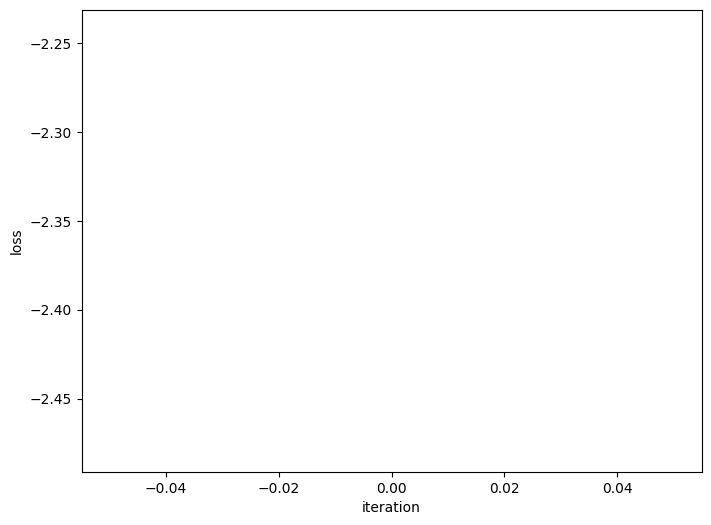

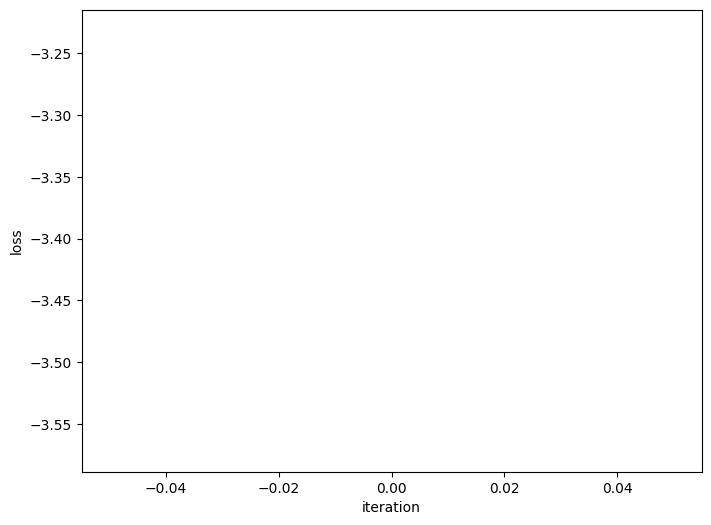

In [12]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [13]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -668.40141  validloss -704.77647±0.00000  bestvalidloss -704.77647  last_update 0
train: iter 1  trainloss -681.13301  validloss -698.46913±0.00000  bestvalidloss -704.77647  last_update 1
train: iter 2  trainloss -660.75486  validloss -665.49949±0.00000  bestvalidloss -704.77647  last_update 2
train: iter 3  trainloss -686.99908  validloss -714.43250±0.00000  bestvalidloss -714.43250  last_update 0
train: iter 4  trainloss -679.42918  validloss -724.03955±0.00000  bestvalidloss -724.03955  last_update 0
train: iter 5  trainloss -680.59403  validloss -694.70761±0.00000  bestvalidloss -724.03955  last_update 1
train: iter 6  trainloss -667.74089  validloss -724.96156±0.00000  bestvalidloss -724.96156  last_update 0
train: iter 7  trainloss -677.86906  validloss -708.24503±0.00000  bestvalidloss -724.96156  last_update 1
train: iter 8  trainloss -677.80331  validloss -665.96869±0.00000  bestvalidloss -724.96156  last_u

train: iter 76  trainloss -703.84856  validloss -706.75641±0.00000  bestvalidloss -768.37981  last_update 6
train: iter 77  trainloss -745.00218  validloss -750.99930±0.00000  bestvalidloss -768.37981  last_update 7
train: iter 78  trainloss -748.94736  validloss -742.53484±0.00000  bestvalidloss -768.37981  last_update 8
train: iter 79  trainloss -694.73806  validloss -749.89388±0.00000  bestvalidloss -768.37981  last_update 9
train: iter 80  trainloss -756.17577  validloss -738.34811±0.00000  bestvalidloss -768.37981  last_update 10
train: iter 81  trainloss -747.63409  validloss -747.70904±0.00000  bestvalidloss -768.37981  last_update 11
train: iter 82  trainloss -742.18261  validloss -724.87286±0.00000  bestvalidloss -768.37981  last_update 12
train: iter 83  trainloss -760.14810  validloss -767.55293±0.00000  bestvalidloss -768.37981  last_update 13
train: iter 84  trainloss -760.57459  validloss -768.05332±0.00000  bestvalidloss -768.37981  last_update 14
train: iter 85  trainlo

train: iter 152  trainloss -810.21335  validloss -754.32171±0.00000  bestvalidloss -822.45636  last_update 18
train: iter 153  trainloss -802.23154  validloss -814.07903±0.00000  bestvalidloss -822.45636  last_update 19
train: iter 154  trainloss -812.09735  validloss -791.30189±0.00000  bestvalidloss -822.45636  last_update 20
train: iter 155  trainloss -834.54012  validloss -809.01665±0.00000  bestvalidloss -822.45636  last_update 21
train: iter 156  trainloss -832.05185  validloss -788.41520±0.00000  bestvalidloss -822.45636  last_update 22
train: iter 157  trainloss -792.30722  validloss -802.61282±0.00000  bestvalidloss -822.45636  last_update 23
train: iter 158  trainloss -820.37034  validloss -764.45382±0.00000  bestvalidloss -822.45636  last_update 24
train: iter 159  trainloss -821.15329  validloss -776.14175±0.00000  bestvalidloss -822.45636  last_update 25
train: iter 160  trainloss -798.71290  validloss -788.70364±0.00000  bestvalidloss -822.45636  last_update 26
train: ite

train: iter 227  trainloss -876.15072  validloss -848.31305±0.00000  bestvalidloss -868.67081  last_update 3
train: iter 228  trainloss -890.93767  validloss -844.14132±0.00000  bestvalidloss -868.67081  last_update 4
train: iter 229  trainloss -870.54066  validloss -845.96183±0.00000  bestvalidloss -868.67081  last_update 5
train: iter 230  trainloss -870.96502  validloss -838.61390±0.00000  bestvalidloss -868.67081  last_update 6
train: iter 231  trainloss -877.97662  validloss -844.83963±0.00000  bestvalidloss -868.67081  last_update 7
train: iter 232  trainloss -893.78944  validloss -851.35104±0.00000  bestvalidloss -868.67081  last_update 8
train: iter 233  trainloss -782.99740  validloss -837.59592±0.00000  bestvalidloss -868.67081  last_update 9
train: iter 234  trainloss -847.06498  validloss -763.21296±0.00000  bestvalidloss -868.67081  last_update 10
train: iter 235  trainloss -885.38107  validloss -825.51723±0.00000  bestvalidloss -868.67081  last_update 11
train: iter 236  

train: iter 302  trainloss -917.11148  validloss -882.79099±0.00000  bestvalidloss -893.42134  last_update 7
train: iter 303  trainloss -803.37494  validloss -804.27867±0.00000  bestvalidloss -893.42134  last_update 8
train: iter 304  trainloss -877.97869  validloss -820.40989±0.00000  bestvalidloss -893.42134  last_update 9
train: iter 305  trainloss -911.82169  validloss -897.11119±0.00000  bestvalidloss -897.11119  last_update 0
train: iter 306  trainloss -907.29111  validloss -883.79343±0.00000  bestvalidloss -897.11119  last_update 1
train: iter 307  trainloss -927.01398  validloss -875.98706±0.00000  bestvalidloss -897.11119  last_update 2
train: iter 308  trainloss -929.54692  validloss -891.79475±0.00000  bestvalidloss -897.11119  last_update 3
train: iter 309  trainloss -851.82666  validloss -881.62580±0.00000  bestvalidloss -897.11119  last_update 4
train: iter 310  trainloss -911.78266  validloss -852.35980±0.00000  bestvalidloss -897.11119  last_update 5
train: iter 311  tr

train: iter 377  trainloss -960.16569  validloss -920.50491±0.00000  bestvalidloss -939.35769  last_update 6
train: iter 378  trainloss -947.77818  validloss -925.02640±0.00000  bestvalidloss -939.35769  last_update 7
train: iter 379  trainloss -777.59469  validloss -903.59718±0.00000  bestvalidloss -939.35769  last_update 8
train: iter 380  trainloss -907.97035  validloss -797.24052±0.00000  bestvalidloss -939.35769  last_update 9
train: iter 381  trainloss -952.39617  validloss -903.35527±0.00000  bestvalidloss -939.35769  last_update 10
train: iter 382  trainloss -968.78898  validloss -910.96820±0.00000  bestvalidloss -939.35769  last_update 11
train: iter 383  trainloss -966.37131  validloss -901.64143±0.00000  bestvalidloss -939.35769  last_update 12
train: iter 384  trainloss -955.01505  validloss -901.35620±0.00000  bestvalidloss -939.35769  last_update 13
train: iter 385  trainloss -942.18377  validloss -896.09646±0.00000  bestvalidloss -939.35769  last_update 14
train: iter 38

train: iter 452  trainloss -1010.81620  validloss -950.90387±0.00000  bestvalidloss -950.90387  last_update 0
train: iter 453  trainloss -1010.62064  validloss -957.11026±0.00000  bestvalidloss -957.11026  last_update 0
train: iter 454  trainloss -988.05752  validloss -933.64521±0.00000  bestvalidloss -957.11026  last_update 1
train: iter 455  trainloss -985.02086  validloss -831.01924±0.00000  bestvalidloss -957.11026  last_update 2
train: iter 456  trainloss -1007.33615  validloss -946.15485±0.00000  bestvalidloss -957.11026  last_update 3
train: iter 457  trainloss -970.62865  validloss -899.13043±0.00000  bestvalidloss -957.11026  last_update 4
train: iter 458  trainloss -996.12124  validloss -906.35914±0.00000  bestvalidloss -957.11026  last_update 5
train: iter 459  trainloss -1003.89690  validloss -904.95955±0.00000  bestvalidloss -957.11026  last_update 6
train: iter 460  trainloss -936.70059  validloss -947.42766±0.00000  bestvalidloss -957.11026  last_update 7
train: iter 461

train: iter 527  trainloss -1037.58215  validloss -977.81507±0.00000  bestvalidloss -977.81507  last_update 0
train: iter 528  trainloss -1025.48897  validloss -913.95237±0.00000  bestvalidloss -977.81507  last_update 1
train: iter 529  trainloss -1008.75669  validloss -879.31085±0.00000  bestvalidloss -977.81507  last_update 2
train: iter 530  trainloss -1028.71417  validloss -945.37188±0.00000  bestvalidloss -977.81507  last_update 3
train: iter 531  trainloss -983.70726  validloss -962.34318±0.00000  bestvalidloss -977.81507  last_update 4
train: iter 532  trainloss -1006.56789  validloss -934.71441±0.00000  bestvalidloss -977.81507  last_update 5
train: iter 533  trainloss -1018.13893  validloss -965.94490±0.00000  bestvalidloss -977.81507  last_update 6
train: iter 534  trainloss -796.54471  validloss -884.76841±0.00000  bestvalidloss -977.81507  last_update 7
train: iter 535  trainloss -974.05700  validloss -866.78901±0.00000  bestvalidloss -977.81507  last_update 8
train: iter 5

train: iter 602  trainloss -1053.04039  validloss -951.31833±0.00000  bestvalidloss -990.40194  last_update 3
train: iter 603  trainloss -1054.05992  validloss -975.32936±0.00000  bestvalidloss -990.40194  last_update 4
train: iter 604  trainloss -1037.69690  validloss -955.20448±0.00000  bestvalidloss -990.40194  last_update 5
train: iter 605  trainloss -1054.73287  validloss -987.43643±0.00000  bestvalidloss -990.40194  last_update 6
train: iter 606  trainloss -1061.68905  validloss -979.63089±0.00000  bestvalidloss -990.40194  last_update 7
train: iter 607  trainloss -1043.10142  validloss -987.55861±0.00000  bestvalidloss -990.40194  last_update 8
train: iter 608  trainloss -1032.86486  validloss -963.05803±0.00000  bestvalidloss -990.40194  last_update 9
train: iter 609  trainloss -1057.45916  validloss -998.90479±0.00000  bestvalidloss -998.90479  last_update 0
train: iter 610  trainloss -1028.38024  validloss -987.00005±0.00000  bestvalidloss -998.90479  last_update 1
train: ite

train: iter 676  trainloss -1055.83936  validloss -989.94586±0.00000  bestvalidloss -1017.76648  last_update 15
train: iter 677  trainloss -1072.29691  validloss -990.42489±0.00000  bestvalidloss -1017.76648  last_update 16
train: iter 678  trainloss -1056.02147  validloss -997.58587±0.00000  bestvalidloss -1017.76648  last_update 17
train: iter 679  trainloss -1066.17723  validloss -999.27381±0.00000  bestvalidloss -1017.76648  last_update 18
train: iter 680  trainloss -1056.90053  validloss -993.71471±0.00000  bestvalidloss -1017.76648  last_update 19
train: iter 681  trainloss -1084.07865  validloss -1008.84887±0.00000  bestvalidloss -1017.76648  last_update 20
train: iter 682  trainloss -1063.96209  validloss -1009.65291±0.00000  bestvalidloss -1017.76648  last_update 21
train: iter 683  trainloss -1083.87618  validloss -1005.63070±0.00000  bestvalidloss -1017.76648  last_update 22
train: iter 684  trainloss -948.27684  validloss -995.78975±0.00000  bestvalidloss -1017.76648  last_

train: iter 750  trainloss -1111.76950  validloss -1035.51542±0.00000  bestvalidloss -1040.63560  last_update 1
train: iter 751  trainloss -1067.82023  validloss -1026.73808±0.00000  bestvalidloss -1040.63560  last_update 2
train: iter 752  trainloss -990.02786  validloss -928.23913±0.00000  bestvalidloss -1040.63560  last_update 3
train: iter 753  trainloss -1084.40878  validloss -991.13280±0.00000  bestvalidloss -1040.63560  last_update 4
train: iter 754  trainloss -1098.10881  validloss -985.72990±0.00000  bestvalidloss -1040.63560  last_update 5
train: iter 755  trainloss -1084.43107  validloss -969.87167±0.00000  bestvalidloss -1040.63560  last_update 6
train: iter 756  trainloss -1093.51591  validloss -1009.57609±0.00000  bestvalidloss -1040.63560  last_update 7
train: iter 757  trainloss -1090.99448  validloss -969.35048±0.00000  bestvalidloss -1040.63560  last_update 8
train: iter 758  trainloss -1102.68437  validloss -1008.62950±0.00000  bestvalidloss -1040.63560  last_update 

train: iter 823  trainloss -1107.13328  validloss -1018.29496±0.00000  bestvalidloss -1053.14562  last_update 12
train: iter 824  trainloss -1057.33260  validloss -996.04314±0.00000  bestvalidloss -1053.14562  last_update 13
train: iter 825  trainloss -1089.39633  validloss -988.00724±0.00000  bestvalidloss -1053.14562  last_update 14
train: iter 826  trainloss -1109.90611  validloss -1004.81939±0.00000  bestvalidloss -1053.14562  last_update 15
train: iter 827  trainloss -1122.91166  validloss -1039.51804±0.00000  bestvalidloss -1053.14562  last_update 16
train: iter 828  trainloss -929.78964  validloss -1022.09832±0.00000  bestvalidloss -1053.14562  last_update 17
train: iter 829  trainloss -1024.29625  validloss -943.67417±0.00000  bestvalidloss -1053.14562  last_update 18
train: iter 830  trainloss -1086.49340  validloss -991.35868±0.00000  bestvalidloss -1053.14562  last_update 19
train: iter 831  trainloss -1112.38611  validloss -998.77941±0.00000  bestvalidloss -1053.14562  last

train: iter 896  trainloss -1124.47890  validloss -1042.03283±0.00000  bestvalidloss -1065.55788  last_update 53
train: iter 897  trainloss -1144.12721  validloss -1068.52702±0.00000  bestvalidloss -1068.52702  last_update 0
train: iter 898  trainloss -1090.25208  validloss -1059.68342±0.00000  bestvalidloss -1068.52702  last_update 1
train: iter 899  trainloss -1105.35107  validloss -1011.35713±0.00000  bestvalidloss -1068.52702  last_update 2
train: iter 900  trainloss -1121.15461  validloss -1053.04097±0.00000  bestvalidloss -1068.52702  last_update 3
train: iter 901  trainloss -1130.71281  validloss -1057.12450±0.00000  bestvalidloss -1068.52702  last_update 4
train: iter 902  trainloss -1109.23510  validloss -1032.37719±0.00000  bestvalidloss -1068.52702  last_update 5
train: iter 903  trainloss -1050.31542  validloss -998.73500±0.00000  bestvalidloss -1068.52702  last_update 6
train: iter 904  trainloss -1125.82780  validloss -1055.93136±0.00000  bestvalidloss -1068.52702  last_u

train: iter 969  trainloss -1166.18219  validloss -1080.01104±0.00000  bestvalidloss -1096.19387  last_update 33
train: iter 970  trainloss -1041.04676  validloss -1087.64852±0.00000  bestvalidloss -1096.19387  last_update 34
train: iter 971  trainloss -1062.74852  validloss -982.32913±0.00000  bestvalidloss -1096.19387  last_update 35
train: iter 972  trainloss -1126.31623  validloss -1058.14346±0.00000  bestvalidloss -1096.19387  last_update 36
train: iter 973  trainloss -1149.19520  validloss -1053.33235±0.00000  bestvalidloss -1096.19387  last_update 37
train: iter 974  trainloss -1144.73616  validloss -1057.48499±0.00000  bestvalidloss -1096.19387  last_update 38
train: iter 975  trainloss -1094.48800  validloss -1036.11069±0.00000  bestvalidloss -1096.19387  last_update 39
train: iter 976  trainloss -1141.32055  validloss -1059.60283±0.00000  bestvalidloss -1096.19387  last_update 40
train: iter 977  trainloss -1157.31035  validloss -1073.91999±0.00000  bestvalidloss -1096.19387 

train: iter 1042  trainloss -1179.77967  validloss -1091.14906±0.00000  bestvalidloss -1120.84543  last_update 5
train: iter 1043  trainloss -1090.39165  validloss -1114.15514±0.00000  bestvalidloss -1120.84543  last_update 6
train: iter 1044  trainloss -1128.72686  validloss -1018.58175±0.00000  bestvalidloss -1120.84543  last_update 7
train: iter 1045  trainloss -1151.95869  validloss -1091.12652±0.00000  bestvalidloss -1120.84543  last_update 8
train: iter 1046  trainloss -840.29271  validloss -1061.91270±0.00000  bestvalidloss -1120.84543  last_update 9
train: iter 1047  trainloss -1011.83156  validloss -920.70378±0.00000  bestvalidloss -1120.84543  last_update 10
train: iter 1048  trainloss -1115.51941  validloss -1038.00913±0.00000  bestvalidloss -1120.84543  last_update 11
train: iter 1049  trainloss -1115.36390  validloss -1012.76225±0.00000  bestvalidloss -1120.84543  last_update 12
train: iter 1050  trainloss -1160.35233  validloss -1088.23905±0.00000  bestvalidloss -1120.845

train: iter 1115  trainloss -1178.73395  validloss -1080.30773±0.00000  bestvalidloss -1135.65375  last_update 28
train: iter 1116  trainloss -1155.68566  validloss -1046.81108±0.00000  bestvalidloss -1135.65375  last_update 29
train: iter 1117  trainloss -1077.05403  validloss -1051.08425±0.00000  bestvalidloss -1135.65375  last_update 30
train: iter 1118  trainloss -1138.31927  validloss -957.11637±0.00000  bestvalidloss -1135.65375  last_update 31
train: iter 1119  trainloss -1165.71780  validloss -1067.73046±0.00000  bestvalidloss -1135.65375  last_update 32
train: iter 1120  trainloss -1174.90525  validloss -1097.90553±0.00000  bestvalidloss -1135.65375  last_update 33
train: iter 1121  trainloss -1179.75723  validloss -1095.11800±0.00000  bestvalidloss -1135.65375  last_update 34
train: iter 1122  trainloss -1198.27241  validloss -1073.59221±0.00000  bestvalidloss -1135.65375  last_update 35
train: iter 1123  trainloss -1164.29328  validloss -1069.43686±0.00000  bestvalidloss -11

train: iter 1187  trainloss -1118.56283  validloss -1058.72884±0.00000  bestvalidloss -1135.65375  last_update 100
train: fin
penalty_target_min tensor(-11.7737) penalty_target_max tensor(13.0179)


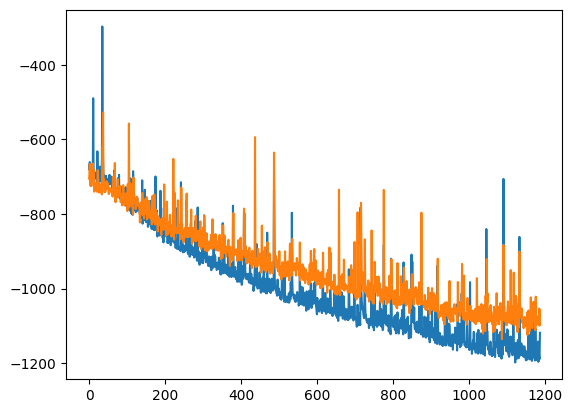

alpha 0.1 default_lr 0.0005


In [14]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
    print("alpha",alpha, "default_lr", default_lr)

In [15]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [16]:
print(datetime.datetime.now())

2023-07-29 07:05:22.894925


# Iter2

In [17]:
policy_evaluation_iter=1

In [18]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [19]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.80050  validloss 3.16597±0.00000  bestvalidloss 3.16597  last_update 0
train: iter 1  trainloss 1.22656  validloss 1.28008±0.00000  bestvalidloss 1.28008  last_update 0
train: iter 2  trainloss 1.08647  validloss 1.06482±0.00000  bestvalidloss 1.06482  last_update 0
train: iter 3  trainloss 0.99497  validloss 0.97172±0.00000  bestvalidloss 0.97172  last_update 0
train: iter 4  trainloss 0.93200  validloss 0.91185±0.00000  bestvalidloss 0.91185  last_update 0
train: iter 5  trainloss 0.88941  validloss 0.87735±0.00000  bestvalidloss 0.87735  last_update 0
train: iter 6  trainloss 0.86064  validloss 0.86042±0.00000  bestvalidloss 0.86042  last_update 0
train: iter 7  trainloss 0.82820  validloss 0.83631±0.00000  bestvalidloss 0.83631  last_update 0
train: iter 8  trainloss 0.81448  validloss 0.81084±0.00000  bestvalidloss 0.81084  last_update 0
train: iter 9  trainloss 0.78809  validloss 0.80974±0.00000  bestvalidloss 0.80974  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.56833  validloss 0.71432±0.00000  bestvalidloss 0.65601  last_update 7
train: iter 84  trainloss 0.56795  validloss 0.68969±0.00000  bestvalidloss 0.65601  last_update 8
train: iter 85  trainloss 0.56767  validloss 0.67212±0.00000  bestvalidloss 0.65601  last_update 9
train: iter 86  trainloss 0.56309  validloss 0.66455±0.00000  bestvalidloss 0.65601  last_update 10
train: iter 87  trainloss 0.56917  validloss 0.65980±0.00000  bestvalidloss 0.65601  last_update 11
train: iter 88  trainloss 0.56633  validloss 0.69051±0.00000  bestvalidloss 0.65601  last_update 12
train: iter 89  trainloss 0.55936  validloss 0.71375±0.00000  bestvalidloss 0.65601  last_update 13
train: iter 90  trainloss 0.56399  validloss 0.69573±0.00000  bestvalidloss 0.65601  last_update 14
train: iter 91  trainloss 0.56290  validloss 0.67338±0.00000  bestvalidloss 0.65601  last_update 15
train: iter 92  trainloss 0.55962  validloss 0.74534±0.00000  bestvalidloss 0.65601  last_update 16
tra

train: iter 165  trainloss 0.52260  validloss 0.66913±0.00000  bestvalidloss 0.64353  last_update 17
train: iter 166  trainloss 0.52795  validloss 0.68293±0.00000  bestvalidloss 0.64353  last_update 18
train: iter 167  trainloss 0.52414  validloss 0.65535±0.00000  bestvalidloss 0.64353  last_update 19
train: iter 168  trainloss 0.52387  validloss 0.65581±0.00000  bestvalidloss 0.64353  last_update 20
train: iter 169  trainloss 0.52577  validloss 0.67176±0.00000  bestvalidloss 0.64353  last_update 21
train: iter 170  trainloss 0.52089  validloss 0.66618±0.00000  bestvalidloss 0.64353  last_update 22
train: iter 171  trainloss 0.52375  validloss 0.64934±0.00000  bestvalidloss 0.64353  last_update 23
train: iter 172  trainloss 0.52096  validloss 0.68325±0.00000  bestvalidloss 0.64353  last_update 24
train: iter 173  trainloss 0.51830  validloss 0.65323±0.00000  bestvalidloss 0.64353  last_update 25
train: iter 174  trainloss 0.52136  validloss 0.64441±0.00000  bestvalidloss 0.64353  last_

train: iter 247  trainloss 0.50499  validloss 0.67281±0.00000  bestvalidloss 0.62918  last_update 17
train: iter 248  trainloss 0.49921  validloss 0.66213±0.00000  bestvalidloss 0.62918  last_update 18
train: iter 249  trainloss 0.50784  validloss 0.64384±0.00000  bestvalidloss 0.62918  last_update 19
train: iter 250  trainloss 0.50679  validloss 0.65882±0.00000  bestvalidloss 0.62918  last_update 20
train: iter 251  trainloss 0.50444  validloss 0.70792±0.00000  bestvalidloss 0.62918  last_update 21
train: iter 252  trainloss 0.50068  validloss 0.69814±0.00000  bestvalidloss 0.62918  last_update 22
train: iter 253  trainloss 0.50044  validloss 0.67808±0.00000  bestvalidloss 0.62918  last_update 23
train: iter 254  trainloss 0.50169  validloss 0.66720±0.00000  bestvalidloss 0.62918  last_update 24
train: iter 255  trainloss 0.50226  validloss 0.65765±0.00000  bestvalidloss 0.62918  last_update 25
train: iter 256  trainloss 0.50085  validloss 0.67944±0.00000  bestvalidloss 0.62918  last_

train: iter 329  trainloss 0.48890  validloss 0.63919±0.00000  bestvalidloss 0.61892  last_update 60
train: iter 330  trainloss 0.48825  validloss 0.65658±0.00000  bestvalidloss 0.61892  last_update 61
train: iter 331  trainloss 0.48669  validloss 0.65117±0.00000  bestvalidloss 0.61892  last_update 62
train: iter 332  trainloss 0.49005  validloss 0.65119±0.00000  bestvalidloss 0.61892  last_update 63
train: iter 333  trainloss 0.48706  validloss 0.65607±0.00000  bestvalidloss 0.61892  last_update 64
train: iter 334  trainloss 0.48592  validloss 0.66779±0.00000  bestvalidloss 0.61892  last_update 65
train: iter 335  trainloss 0.49253  validloss 0.67167±0.00000  bestvalidloss 0.61892  last_update 66
train: iter 336  trainloss 0.48953  validloss 0.64386±0.00000  bestvalidloss 0.61892  last_update 67
train: iter 337  trainloss 0.48566  validloss 0.63807±0.00000  bestvalidloss 0.61892  last_update 68
train: iter 338  trainloss 0.49509  validloss 0.72103±0.00000  bestvalidloss 0.61892  last_

train_loss:  -7.1666231855154034
valid_loss:  -7.585217468070982
weight_alpha 1.0 h_min_tilde -11.773722 ell_tilde -7.25034204202652 kappa_tilde 0.00047018468594863986
train_loss:  -5.121757845565677
valid_loss:  -4.864537071990966
weight_alpha 0.1 h_min_tilde -11.773722 ell_tilde -5.0703136908507345 kappa_tilde 0.0003862354863762202


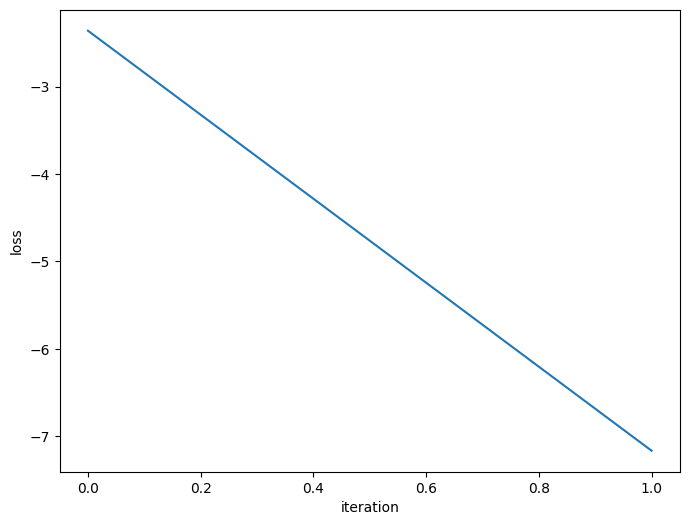

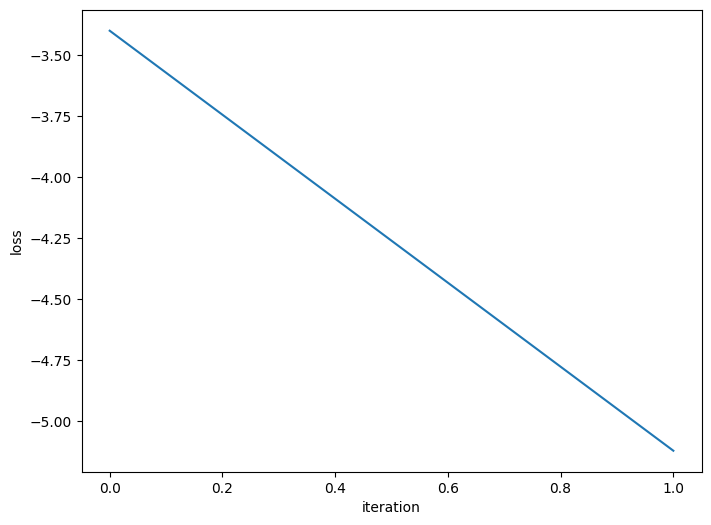

In [20]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [21]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1001.89230  validloss -971.46465±0.00000  bestvalidloss -971.46465  last_update 0
train: iter 1  trainloss -1005.86539  validloss -977.38129±0.00000  bestvalidloss -977.38129  last_update 0
train: iter 2  trainloss -993.19456  validloss -966.85517±0.00000  bestvalidloss -977.38129  last_update 1
train: iter 3  trainloss -996.05550  validloss -957.23452±0.00000  bestvalidloss -977.38129  last_update 2
train: iter 4  trainloss -995.86853  validloss -952.65782±0.00000  bestvalidloss -977.38129  last_update 3
train: iter 5  trainloss -976.02621  validloss -941.69753±0.00000  bestvalidloss -977.38129  last_update 4
train: iter 6  trainloss -981.41838  validloss -899.78375±0.00000  bestvalidloss -977.38129  last_update 5
train: iter 7  trainloss -1030.97674  validloss -987.54520±0.00000  bestvalidloss -987.54520  last_update 0
train: iter 8  trainloss -1045.30448  validloss -978.47321±0.00000  bestvalidloss -987.54520  la

train: iter 74  trainloss -989.53579  validloss -961.49034±0.00000  bestvalidloss -1020.82162  last_update 48
train: iter 75  trainloss -972.32609  validloss -981.96601±0.00000  bestvalidloss -1020.82162  last_update 49
train: iter 76  trainloss -977.43395  validloss -882.63302±0.00000  bestvalidloss -1020.82162  last_update 50
train: iter 77  trainloss -1033.56070  validloss -996.61495±0.00000  bestvalidloss -1020.82162  last_update 51
train: iter 78  trainloss -1030.52568  validloss -991.92069±0.00000  bestvalidloss -1020.82162  last_update 52
train: iter 79  trainloss -1039.12662  validloss -992.22648±0.00000  bestvalidloss -1020.82162  last_update 53
train: iter 80  trainloss -1004.11397  validloss -1004.16796±0.00000  bestvalidloss -1020.82162  last_update 54
train: iter 81  trainloss -1032.27901  validloss -987.52359±0.00000  bestvalidloss -1020.82162  last_update 55
train: iter 82  trainloss -1028.67488  validloss -1022.06862±0.00000  bestvalidloss -1022.06862  last_update 0
tra

train: iter 148  trainloss -1053.03317  validloss -1006.56461±0.00000  bestvalidloss -1037.06213  last_update 33
train: iter 149  trainloss -1007.15560  validloss -1018.04128±0.00000  bestvalidloss -1037.06213  last_update 34
train: iter 150  trainloss -1032.16034  validloss -952.33169±0.00000  bestvalidloss -1037.06213  last_update 35
train: iter 151  trainloss -1038.67677  validloss -1033.85538±0.00000  bestvalidloss -1037.06213  last_update 36
train: iter 152  trainloss -981.71300  validloss -1027.19532±0.00000  bestvalidloss -1037.06213  last_update 37
train: iter 153  trainloss -1029.92803  validloss -973.77330±0.00000  bestvalidloss -1037.06213  last_update 38
train: iter 154  trainloss -1030.90955  validloss -1011.27892±0.00000  bestvalidloss -1037.06213  last_update 39
train: iter 155  trainloss -1037.94068  validloss -994.39438±0.00000  bestvalidloss -1037.06213  last_update 40
train: iter 156  trainloss -1022.44129  validloss -1019.30771±0.00000  bestvalidloss -1037.06213  la

train: iter 222  trainloss -1038.47987  validloss -1011.08855±0.00000  bestvalidloss -1039.51277  last_update 36
train: iter 223  trainloss -1049.29031  validloss -1022.75415±0.00000  bestvalidloss -1039.51277  last_update 37
train: iter 224  trainloss -1056.80879  validloss -1041.20093±0.00000  bestvalidloss -1041.20093  last_update 0
train: iter 225  trainloss -1017.18094  validloss -1026.95049±0.00000  bestvalidloss -1041.20093  last_update 1
train: iter 226  trainloss -1033.99753  validloss -994.89011±0.00000  bestvalidloss -1041.20093  last_update 2
train: iter 227  trainloss -1055.71913  validloss -1026.39230±0.00000  bestvalidloss -1041.20093  last_update 3
train: iter 228  trainloss -1043.63216  validloss -1027.16282±0.00000  bestvalidloss -1041.20093  last_update 4
train: iter 229  trainloss -817.66381  validloss -833.54236±0.00000  bestvalidloss -1041.20093  last_update 5
train: iter 230  trainloss -1010.74914  validloss -824.29496±0.00000  bestvalidloss -1041.20093  last_upd

train: iter 296  trainloss -1041.36554  validloss -1019.28447±0.00000  bestvalidloss -1052.04189  last_update 16
train: iter 297  trainloss -1053.97319  validloss -1030.43973±0.00000  bestvalidloss -1052.04189  last_update 17
train: iter 298  trainloss -1054.62777  validloss -1036.16173±0.00000  bestvalidloss -1052.04189  last_update 18
train: iter 299  trainloss -889.82268  validloss -998.69986±0.00000  bestvalidloss -1052.04189  last_update 19
train: iter 300  trainloss -973.73849  validloss -867.51670±0.00000  bestvalidloss -1052.04189  last_update 20
train: iter 301  trainloss -1033.01329  validloss -994.03369±0.00000  bestvalidloss -1052.04189  last_update 21
train: iter 302  trainloss -1024.29695  validloss -1015.97292±0.00000  bestvalidloss -1052.04189  last_update 22
train: iter 303  trainloss -998.94859  validloss -800.26237±0.00000  bestvalidloss -1052.04189  last_update 23
train: iter 304  trainloss -1044.73326  validloss -1038.02575±0.00000  bestvalidloss -1052.04189  last_

train: iter 369  trainloss -995.75478  validloss -995.44263±0.00000  bestvalidloss -1061.99319  last_update 16
train: iter 370  trainloss -1060.30663  validloss -1027.23331±0.00000  bestvalidloss -1061.99319  last_update 17
train: iter 371  trainloss -1045.37105  validloss -1037.74037±0.00000  bestvalidloss -1061.99319  last_update 18
train: iter 372  trainloss -1023.42656  validloss -1023.15411±0.00000  bestvalidloss -1061.99319  last_update 19
train: iter 373  trainloss -1036.78303  validloss -1025.18976±0.00000  bestvalidloss -1061.99319  last_update 20
train: iter 374  trainloss -1065.88836  validloss -1020.70021±0.00000  bestvalidloss -1061.99319  last_update 21
train: iter 375  trainloss -1061.52754  validloss -1047.00657±0.00000  bestvalidloss -1061.99319  last_update 22
train: iter 376  trainloss -1066.53514  validloss -1051.57690±0.00000  bestvalidloss -1061.99319  last_update 23
train: iter 377  trainloss -856.25048  validloss -1039.05063±0.00000  bestvalidloss -1061.99319  l

train: iter 442  trainloss -1042.51407  validloss -984.41748±0.00000  bestvalidloss -1061.99319  last_update 89
train: iter 443  trainloss -1064.78210  validloss -1048.45457±0.00000  bestvalidloss -1061.99319  last_update 90
train: iter 444  trainloss -1066.31089  validloss -1056.37903±0.00000  bestvalidloss -1061.99319  last_update 91
train: iter 445  trainloss -1039.53554  validloss -1045.88329±0.00000  bestvalidloss -1061.99319  last_update 92
train: iter 446  trainloss -1005.76729  validloss -1036.73576±0.00000  bestvalidloss -1061.99319  last_update 93
train: iter 447  trainloss -1053.27257  validloss -1012.19813±0.00000  bestvalidloss -1061.99319  last_update 94
train: iter 448  trainloss -1073.13105  validloss -1037.92016±0.00000  bestvalidloss -1061.99319  last_update 95
train: iter 449  trainloss -1000.24807  validloss -1047.86604±0.00000  bestvalidloss -1061.99319  last_update 96
train: iter 450  trainloss -1039.74723  validloss -972.21771±0.00000  bestvalidloss -1061.99319  

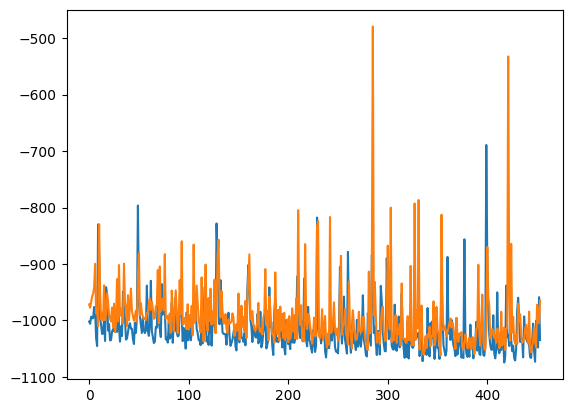

alpha 0.1 default_lr 0.0005


In [22]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [23]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [24]:
print(datetime.datetime.now())

2023-07-29 07:32:08.502658


In [25]:
# if policy_evaluation_iter<policy_evaluation_maxiter:
#     normalized_loss_array = np.array(normalized_loss_list)
#     plt.figure(figsize=(16,12))
#     plt.plot(normalized_loss_array[:,0])
#     plt.xlabel("iteration")
#     plt.ylabel("loss")


# Iter 3

In [26]:
policy_evaluation_iter=2

In [27]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [28]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.63678  validloss 1.00154±0.00000  bestvalidloss 1.00154  last_update 0
train: iter 1  trainloss 0.57885  validloss 0.71580±0.00000  bestvalidloss 0.71580  last_update 0
train: iter 2  trainloss 0.57322  validloss 0.68652±0.00000  bestvalidloss 0.68652  last_update 0
train: iter 3  trainloss 0.56479  validloss 0.67037±0.00000  bestvalidloss 0.67037  last_update 0
train: iter 4  trainloss 0.55829  validloss 0.67668±0.00000  bestvalidloss 0.67037  last_update 1
train: iter 5  trainloss 0.55625  validloss 0.68168±0.00000  bestvalidloss 0.67037  last_update 2
train: iter 6  trainloss 0.54969  validloss 0.67574±0.00000  bestvalidloss 0.67037  last_update 3
train: iter 7  trainloss 0.54981  validloss 0.66235±0.00000  bestvalidloss 0.66235  last_update 0
train: iter 8  trainloss 0.54714  validloss 0.66084±0.00000  bestvalidloss 0.66084  last_update 0
train: iter 9  trainloss 0.54505  validloss 0.67840±0.00000  bestvalidloss 0.66084  last_update 1
train: iter 10  trai

train: iter 83  trainloss 0.50841  validloss 0.67053±0.00000  bestvalidloss 0.64795  last_update 53
train: iter 84  trainloss 0.50462  validloss 0.66120±0.00000  bestvalidloss 0.64795  last_update 54
train: iter 85  trainloss 0.50566  validloss 0.66676±0.00000  bestvalidloss 0.64795  last_update 55
train: iter 86  trainloss 0.50739  validloss 0.66248±0.00000  bestvalidloss 0.64795  last_update 56
train: iter 87  trainloss 0.50627  validloss 0.68171±0.00000  bestvalidloss 0.64795  last_update 57
train: iter 88  trainloss 0.50698  validloss 0.66106±0.00000  bestvalidloss 0.64795  last_update 58
train: iter 89  trainloss 0.50525  validloss 0.66382±0.00000  bestvalidloss 0.64795  last_update 59
train: iter 90  trainloss 0.51284  validloss 0.66177±0.00000  bestvalidloss 0.64795  last_update 60
train: iter 91  trainloss 0.50531  validloss 0.66759±0.00000  bestvalidloss 0.64795  last_update 61
train: iter 92  trainloss 0.49939  validloss 0.68232±0.00000  bestvalidloss 0.64795  last_update 62


train_loss:  -6.3071079891055835
valid_loss:  -7.035988033485414
weight_alpha 1.0 h_min_tilde -11.92499 ell_tilde -6.45288399798155 kappa_tilde 0.00042748685118492434
train_loss:  -5.071970849323273
valid_loss:  -4.9416006050109855
weight_alpha 0.1 h_min_tilde -11.92499 ell_tilde -5.045896800460815 kappa_tilde 0.00038127156121584314


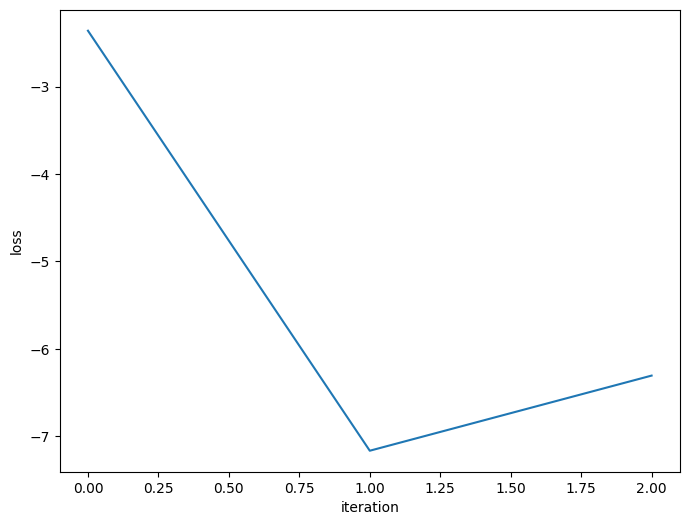

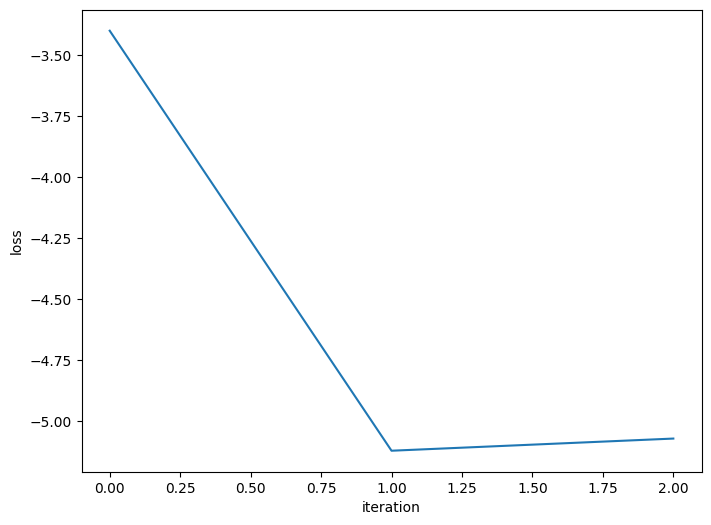

In [29]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")


In [30]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1001.66557  validloss -986.50650±0.00000  bestvalidloss -986.50650  last_update 0
train: iter 1  trainloss -1014.46946  validloss -996.30401±0.00000  bestvalidloss -996.30401  last_update 0
train: iter 2  trainloss -979.83531  validloss -924.30447±0.00000  bestvalidloss -996.30401  last_update 1
train: iter 3  trainloss -992.43749  validloss -985.01423±0.00000  bestvalidloss -996.30401  last_update 2
train: iter 4  trainloss -841.46740  validloss -955.32861±0.00000  bestvalidloss -996.30401  last_update 3
train: iter 5  trainloss -973.61920  validloss -902.85279±0.00000  bestvalidloss -996.30401  last_update 4
train: iter 6  trainloss -1005.77743  validloss -1014.02755±0.00000  bestvalidloss -1014.02755  last_update 0
train: iter 7  trainloss -1012.13320  validloss -967.40239±0.00000  bestvalidloss -1014.02755  last_update 1
train: iter 8  trainloss -1013.54219  validloss -1003.82839±0.00000  bestvalidloss -1014.027

train: iter 74  trainloss -1018.81812  validloss -1002.27469±0.00000  bestvalidloss -1024.12621  last_update 55
train: iter 75  trainloss -1023.75491  validloss -1002.37449±0.00000  bestvalidloss -1024.12621  last_update 56
train: iter 76  trainloss -988.44222  validloss -1003.68031±0.00000  bestvalidloss -1024.12621  last_update 57
train: iter 77  trainloss -1014.99023  validloss -992.71918±0.00000  bestvalidloss -1024.12621  last_update 58
train: iter 78  trainloss -1031.20295  validloss -1005.30428±0.00000  bestvalidloss -1024.12621  last_update 59
train: iter 79  trainloss -1012.52817  validloss -1012.86672±0.00000  bestvalidloss -1024.12621  last_update 60
train: iter 80  trainloss -1024.64357  validloss -1007.40227±0.00000  bestvalidloss -1024.12621  last_update 61
train: iter 81  trainloss -1013.41345  validloss -983.45322±0.00000  bestvalidloss -1024.12621  last_update 62
train: iter 82  trainloss -1003.06912  validloss -1015.34256±0.00000  bestvalidloss -1024.12621  last_updat

train: iter 148  trainloss -1019.76442  validloss -1000.38219±0.00000  bestvalidloss -1032.94881  last_update 58
train: iter 149  trainloss -1016.14250  validloss -958.50203±0.00000  bestvalidloss -1032.94881  last_update 59
train: iter 150  trainloss -1011.54937  validloss -972.46620±0.00000  bestvalidloss -1032.94881  last_update 60
train: iter 151  trainloss -1021.67163  validloss -1003.86268±0.00000  bestvalidloss -1032.94881  last_update 61
train: iter 152  trainloss -1005.35553  validloss -985.76764±0.00000  bestvalidloss -1032.94881  last_update 62
train: iter 153  trainloss -1027.99168  validloss -985.89380±0.00000  bestvalidloss -1032.94881  last_update 63
train: iter 154  trainloss -1034.13365  validloss -979.08235±0.00000  bestvalidloss -1032.94881  last_update 64
train: iter 155  trainloss -1015.43998  validloss -994.24562±0.00000  bestvalidloss -1032.94881  last_update 65
train: iter 156  trainloss -1023.81121  validloss -965.64480±0.00000  bestvalidloss -1032.94881  last_

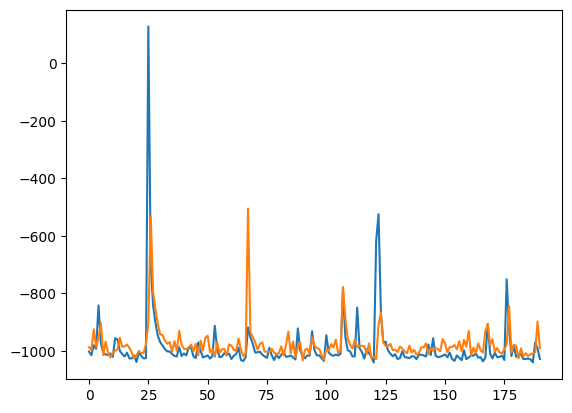

alpha 0.1 default_lr 0.0005


In [31]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [32]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [33]:
print(datetime.datetime.now())

2023-07-29 07:55:11.718334


# Iter 4

In [34]:
policy_evaluation_iter=3

In [35]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [36]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.62097  validloss 0.68241±0.00000  bestvalidloss 0.68241  last_update 0
train: iter 1  trainloss 0.60058  validloss 0.63360±0.00000  bestvalidloss 0.63360  last_update 0
train: iter 2  trainloss 0.59080  validloss 0.63925±0.00000  bestvalidloss 0.63360  last_update 1
train: iter 3  trainloss 0.58821  validloss 0.62896±0.00000  bestvalidloss 0.62896  last_update 0
train: iter 4  trainloss 0.58387  validloss 0.63433±0.00000  bestvalidloss 0.62896  last_update 1
train: iter 5  trainloss 0.57609  validloss 0.62135±0.00000  bestvalidloss 0.62135  last_update 0
train: iter 6  trainloss 0.57543  validloss 0.63012±0.00000  bestvalidloss 0.62135  last_update 1
train: iter 7  trainloss 0.57133  validloss 0.62709±0.00000  bestvalidloss 0.62135  last_update 2
train: iter 8  trainloss 0.56646  validloss 0.63960±0.00000  bestvalidloss 0.62135  last_update 3
train: iter 9  trainloss 0.56848  validloss 0.62671±0.00000  bestvalidloss 0.62135  last_update 4
train: iter 10  trai

train: iter 84  trainloss 0.52418  validloss 0.65210±0.00000  bestvalidloss 0.61311  last_update 28
train: iter 85  trainloss 0.52258  validloss 0.63559±0.00000  bestvalidloss 0.61311  last_update 29
train: iter 86  trainloss 0.52825  validloss 0.63384±0.00000  bestvalidloss 0.61311  last_update 30
train: iter 87  trainloss 0.52281  validloss 0.63161±0.00000  bestvalidloss 0.61311  last_update 31
train: iter 88  trainloss 0.52671  validloss 0.64876±0.00000  bestvalidloss 0.61311  last_update 32
train: iter 89  trainloss 0.52158  validloss 0.64233±0.00000  bestvalidloss 0.61311  last_update 33
train: iter 90  trainloss 0.52409  validloss 0.63242±0.00000  bestvalidloss 0.61311  last_update 34
train: iter 91  trainloss 0.52154  validloss 0.63103±0.00000  bestvalidloss 0.61311  last_update 35
train: iter 92  trainloss 0.52157  validloss 0.63610±0.00000  bestvalidloss 0.61311  last_update 36
train: iter 93  trainloss 0.52367  validloss 0.63016±0.00000  bestvalidloss 0.61311  last_update 37


train_loss:  -9.20018641859293
valid_loss:  -11.470802238559724
weight_alpha 1.0 h_min_tilde -11.962091 ell_tilde -9.654309582586288 kappa_tilde 0.0006582678158819939
train_loss:  -5.722670091223717
valid_loss:  -5.61868147201538
weight_alpha 0.1 h_min_tilde -11.962091 ell_tilde -5.70187236738205 kappa_tilde 0.0003996733899506165


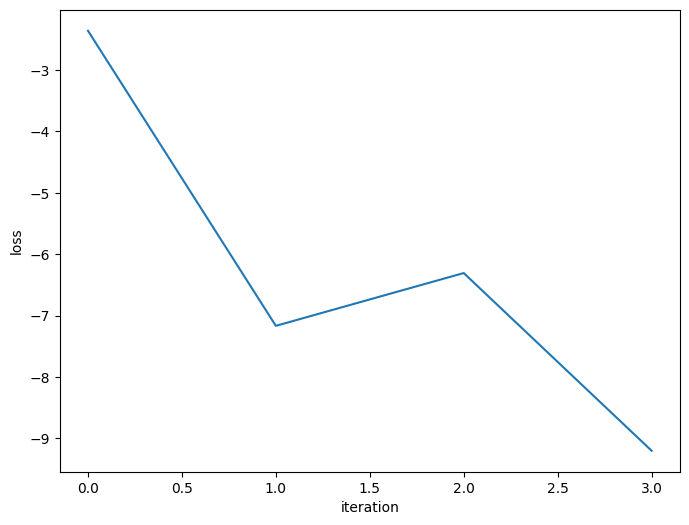

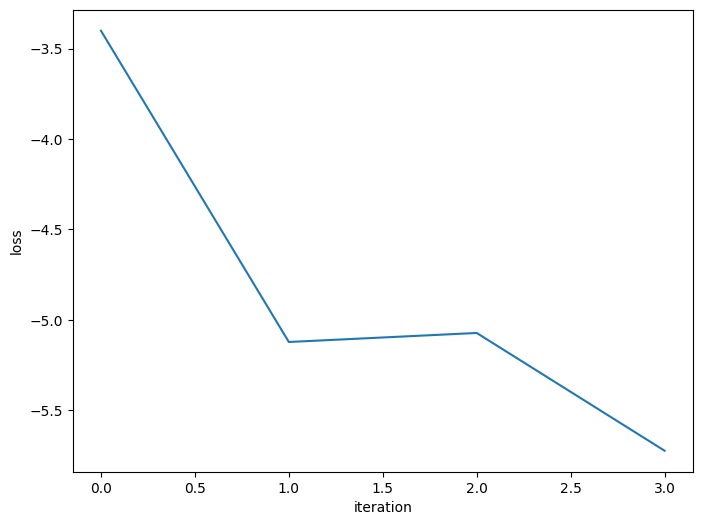

In [37]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [38]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1132.35687  validloss -1124.94136±0.00000  bestvalidloss -1124.94136  last_update 0
train: iter 1  trainloss -1127.30122  validloss -1131.01073±0.00000  bestvalidloss -1131.01073  last_update 0
train: iter 2  trainloss -1137.75306  validloss -1114.22981±0.00000  bestvalidloss -1131.01073  last_update 1
train: iter 3  trainloss -1152.71556  validloss -1128.85153±0.00000  bestvalidloss -1131.01073  last_update 2
train: iter 4  trainloss -1069.60230  validloss -1128.39381±0.00000  bestvalidloss -1131.01073  last_update 3
train: iter 5  trainloss -1081.02730  validloss -1110.88059±0.00000  bestvalidloss -1131.01073  last_update 4
train: iter 6  trainloss -1148.60570  validloss -1082.52328±0.00000  bestvalidloss -1131.01073  last_update 5
train: iter 7  trainloss -1152.47001  validloss -1132.69369±0.00000  bestvalidloss -1132.69369  last_update 0
train: iter 8  trainloss -1157.35177  validloss -1129.87105±0.00000  bestva

train: iter 74  trainloss -1143.07326  validloss -1141.31697±0.00000  bestvalidloss -1159.05494  last_update 17
train: iter 75  trainloss -1162.34292  validloss -1132.26845±0.00000  bestvalidloss -1159.05494  last_update 18
train: iter 76  trainloss -1163.02491  validloss -1125.72373±0.00000  bestvalidloss -1159.05494  last_update 19
train: iter 77  trainloss -1108.36357  validloss -1093.97734±0.00000  bestvalidloss -1159.05494  last_update 20
train: iter 78  trainloss -1142.55820  validloss -1106.18642±0.00000  bestvalidloss -1159.05494  last_update 21
train: iter 79  trainloss -1160.41733  validloss -1128.64176±0.00000  bestvalidloss -1159.05494  last_update 22
train: iter 80  trainloss -1125.18882  validloss -1111.60095±0.00000  bestvalidloss -1159.05494  last_update 23
train: iter 81  trainloss -1130.79267  validloss -1107.75963±0.00000  bestvalidloss -1159.05494  last_update 24
train: iter 82  trainloss -1097.66521  validloss -1087.50865±0.00000  bestvalidloss -1159.05494  last_up

train: iter 147  trainloss -1108.27390  validloss -1161.07248±0.00000  bestvalidloss -1161.07248  last_update 0
train: iter 148  trainloss -1106.89250  validloss -1054.48467±0.00000  bestvalidloss -1161.07248  last_update 1
train: iter 149  trainloss -1135.06967  validloss -1115.33206±0.00000  bestvalidloss -1161.07248  last_update 2
train: iter 150  trainloss -1103.27196  validloss -1103.77135±0.00000  bestvalidloss -1161.07248  last_update 3
train: iter 151  trainloss -1141.78856  validloss -1114.52950±0.00000  bestvalidloss -1161.07248  last_update 4
train: iter 152  trainloss -1165.13118  validloss -1145.53005±0.00000  bestvalidloss -1161.07248  last_update 5
train: iter 153  trainloss -1171.25927  validloss -1152.26643±0.00000  bestvalidloss -1161.07248  last_update 6
train: iter 154  trainloss -1123.41086  validloss -1128.93904±0.00000  bestvalidloss -1161.07248  last_update 7
train: iter 155  trainloss -1166.02189  validloss -1117.67487±0.00000  bestvalidloss -1161.07248  last_u

train: iter 220  trainloss -1095.97908  validloss -1119.74564±0.00000  bestvalidloss -1161.07248  last_update 73
train: iter 221  trainloss -1115.40638  validloss -1070.33344±0.00000  bestvalidloss -1161.07248  last_update 74
train: iter 222  trainloss -1130.39178  validloss -1116.37260±0.00000  bestvalidloss -1161.07248  last_update 75
train: iter 223  trainloss -793.86321  validloss -1113.64417±0.00000  bestvalidloss -1161.07248  last_update 76
train: iter 224  trainloss -1028.36341  validloss -955.18937±0.00000  bestvalidloss -1161.07248  last_update 77
train: iter 225  trainloss -1109.59530  validloss -1092.77564±0.00000  bestvalidloss -1161.07248  last_update 78
train: iter 226  trainloss -1115.56569  validloss -1107.73735±0.00000  bestvalidloss -1161.07248  last_update 79
train: iter 227  trainloss -1130.13212  validloss -1118.19636±0.00000  bestvalidloss -1161.07248  last_update 80
train: iter 228  trainloss -1132.90814  validloss -1094.59828±0.00000  bestvalidloss -1161.07248  

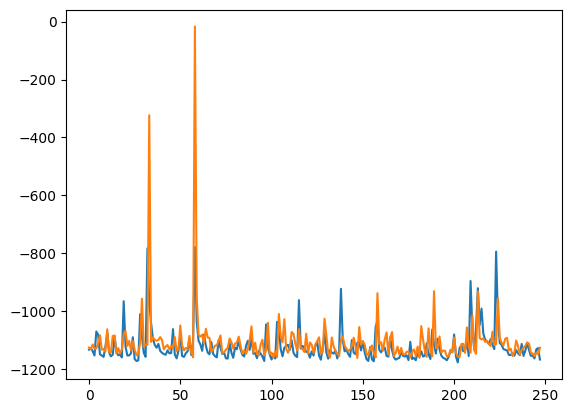

alpha 0.1 default_lr 0.0005


In [39]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [40]:
print(datetime.datetime.now())

2023-07-29 08:20:38.384012


# Iter 5

In [41]:
policy_evaluation_iter=4

In [42]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [43]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.63341  validloss 0.75977±0.00000  bestvalidloss 0.75977  last_update 0
train: iter 1  trainloss 0.59855  validloss 0.64179±0.00000  bestvalidloss 0.64179  last_update 0
train: iter 2  trainloss 0.58897  validloss 0.64215±0.00000  bestvalidloss 0.64179  last_update 1
train: iter 3  trainloss 0.58273  validloss 0.61826±0.00000  bestvalidloss 0.61826  last_update 0
train: iter 4  trainloss 0.57324  validloss 0.62169±0.00000  bestvalidloss 0.61826  last_update 1
train: iter 5  trainloss 0.57853  validloss 0.62115±0.00000  bestvalidloss 0.61826  last_update 2
train: iter 6  trainloss 0.57191  validloss 0.60714±0.00000  bestvalidloss 0.60714  last_update 0
train: iter 7  trainloss 0.57096  validloss 0.61935±0.00000  bestvalidloss 0.60714  last_update 1
train: iter 8  trainloss 0.56722  validloss 0.60940±0.00000  bestvalidloss 0.60714  last_update 2
train: iter 9  trainloss 0.56670  validloss 0.60667±0.00000  bestvalidloss 0.60667  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.52756  validloss 0.61270±0.00000  bestvalidloss 0.59743  last_update 29
train: iter 84  trainloss 0.52608  validloss 0.59716±0.00000  bestvalidloss 0.59716  last_update 0
train: iter 85  trainloss 0.52931  validloss 0.59962±0.00000  bestvalidloss 0.59716  last_update 1
train: iter 86  trainloss 0.52973  validloss 0.60084±0.00000  bestvalidloss 0.59716  last_update 2
train: iter 87  trainloss 0.52950  validloss 0.60799±0.00000  bestvalidloss 0.59716  last_update 3
train: iter 88  trainloss 0.52552  validloss 0.60082±0.00000  bestvalidloss 0.59716  last_update 4
train: iter 89  trainloss 0.52673  validloss 0.61883±0.00000  bestvalidloss 0.59716  last_update 5
train: iter 90  trainloss 0.52928  validloss 0.61310±0.00000  bestvalidloss 0.59716  last_update 6
train: iter 91  trainloss 0.52477  validloss 0.60998±0.00000  bestvalidloss 0.59716  last_update 7
train: iter 92  trainloss 0.52549  validloss 0.60686±0.00000  bestvalidloss 0.59716  last_update 8
train: it

train: iter 165  trainloss 0.51388  validloss 0.62918±0.00000  bestvalidloss 0.59716  last_update 81
train: iter 166  trainloss 0.51415  validloss 0.61879±0.00000  bestvalidloss 0.59716  last_update 82
train: iter 167  trainloss 0.51538  validloss 0.63241±0.00000  bestvalidloss 0.59716  last_update 83
train: iter 168  trainloss 0.51134  validloss 0.61978±0.00000  bestvalidloss 0.59716  last_update 84
train: iter 169  trainloss 0.51248  validloss 0.61094±0.00000  bestvalidloss 0.59716  last_update 85
train: iter 170  trainloss 0.51424  validloss 0.61741±0.00000  bestvalidloss 0.59716  last_update 86
train: iter 171  trainloss 0.51384  validloss 0.62354±0.00000  bestvalidloss 0.59716  last_update 87
train: iter 172  trainloss 0.51764  validloss 0.63095±0.00000  bestvalidloss 0.59716  last_update 88
train: iter 173  trainloss 0.51560  validloss 0.61579±0.00000  bestvalidloss 0.59716  last_update 89
train: iter 174  trainloss 0.51590  validloss 0.61443±0.00000  bestvalidloss 0.59716  last_

train_loss:  -6.933118467193843
valid_loss:  -8.401243784618377
weight_alpha 1.0 h_min_tilde -11.914923 ell_tilde -7.22674353067875 kappa_tilde 0.00046184675749987573
train_loss:  -5.212491118311881
valid_loss:  -5.152373511505127
weight_alpha 0.1 h_min_tilde -11.914923 ell_tilde -5.20046759695053 kappa_tilde 0.00038591762412878034


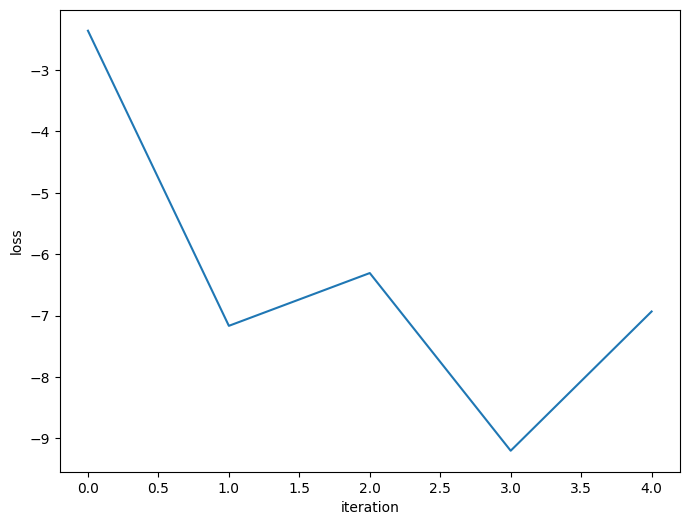

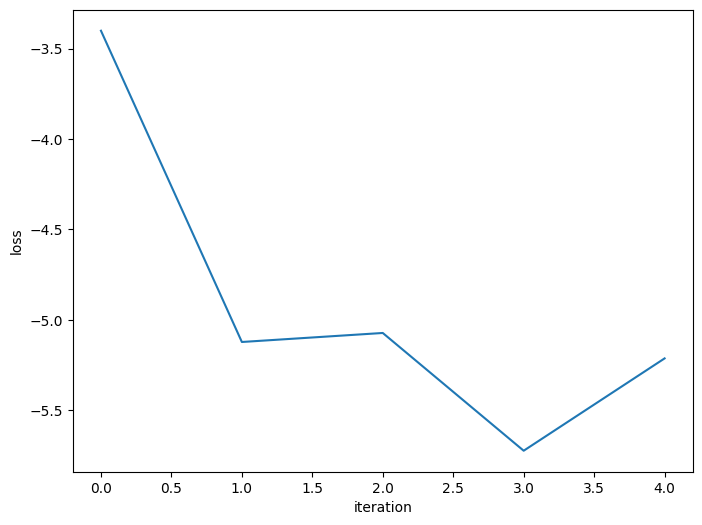

In [44]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [45]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1009.20905  validloss -1032.59787±0.00000  bestvalidloss -1032.59787  last_update 0
train: iter 1  trainloss -1059.79575  validloss -1025.40856±0.00000  bestvalidloss -1032.59787  last_update 1
train: iter 2  trainloss -1036.11290  validloss -1036.98358±0.00000  bestvalidloss -1036.98358  last_update 0
train: iter 3  trainloss -1021.94674  validloss -1006.84689±0.00000  bestvalidloss -1036.98358  last_update 1
train: iter 4  trainloss -1046.65199  validloss -1028.11605±0.00000  bestvalidloss -1036.98358  last_update 2
train: iter 5  trainloss -981.07406  validloss -1000.81632±0.00000  bestvalidloss -1036.98358  last_update 3
train: iter 6  trainloss -962.22115  validloss -899.99036±0.00000  bestvalidloss -1036.98358  last_update 4
train: iter 7  trainloss -1059.10055  validloss -1024.97731±0.00000  bestvalidloss -1036.98358  last_update 5
train: iter 8  trainloss -1060.59797  validloss -1044.86177±0.00000  bestvalid

train: iter 74  trainloss -1032.31614  validloss -1061.30962±0.00000  bestvalidloss -1068.79000  last_update 45
train: iter 75  trainloss -1027.41105  validloss -1019.50588±0.00000  bestvalidloss -1068.79000  last_update 46
train: iter 76  trainloss -1049.60481  validloss -1047.36668±0.00000  bestvalidloss -1068.79000  last_update 47
train: iter 77  trainloss -1015.96862  validloss -1035.44227±0.00000  bestvalidloss -1068.79000  last_update 48
train: iter 78  trainloss -1044.98954  validloss -1028.92751±0.00000  bestvalidloss -1068.79000  last_update 49
train: iter 79  trainloss -1064.59892  validloss -1042.42938±0.00000  bestvalidloss -1068.79000  last_update 50
train: iter 80  trainloss -1005.81497  validloss -1048.32903±0.00000  bestvalidloss -1068.79000  last_update 51
train: iter 81  trainloss -785.11254  validloss -1017.80252±0.00000  bestvalidloss -1068.79000  last_update 52
train: iter 82  trainloss -934.93391  validloss -877.82325±0.00000  bestvalidloss -1068.79000  last_updat

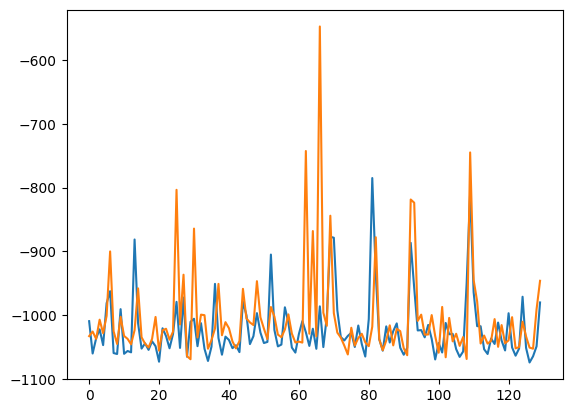

alpha 0.1 default_lr 0.0005


In [46]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [47]:
print(datetime.datetime.now())

2023-07-29 08:43:24.234363


# 評価関数計算

In [48]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [49]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.58854  validloss 0.68829±0.00000  bestvalidloss 0.68829  last_update 0
train: iter 1  trainloss 0.56624  validloss 0.67622±0.00000  bestvalidloss 0.67622  last_update 0
train: iter 2  trainloss 0.55886  validloss 0.67893±0.00000  bestvalidloss 0.67622  last_update 1
train: iter 3  trainloss 0.55229  validloss 0.65967±0.00000  bestvalidloss 0.65967  last_update 0
train: iter 4  trainloss 0.55153  validloss 0.67792±0.00000  bestvalidloss 0.65967  last_update 1
train: iter 5  trainloss 0.54600  validloss 0.66937±0.00000  bestvalidloss 0.65967  last_update 2
train: iter 6  trainloss 0.55316  validloss 0.70931±0.00000  bestvalidloss 0.65967  last_update 3
train: iter 7  trainloss 0.54428  validloss 0.66662±0.00000  bestvalidloss 0.65967  last_update 4
train: iter 8  trainloss 0.54375  validloss 0.67789±0.00000  bestvalidloss 0.65967  last_update 5
train: iter 9  trainloss 0.54031  validloss 0.68010±0.00000  bestvalidloss 0.65967  last_update 6
train: iter 10  trai

train: iter 83  trainloss 0.51442  validloss 0.67540±0.00000  bestvalidloss 0.65967  last_update 80
train: iter 84  trainloss 0.51208  validloss 0.69944±0.00000  bestvalidloss 0.65967  last_update 81
train: iter 85  trainloss 0.51690  validloss 0.68605±0.00000  bestvalidloss 0.65967  last_update 82
train: iter 86  trainloss 0.51485  validloss 0.69119±0.00000  bestvalidloss 0.65967  last_update 83
train: iter 87  trainloss 0.51777  validloss 0.67816±0.00000  bestvalidloss 0.65967  last_update 84
train: iter 88  trainloss 0.51390  validloss 0.71617±0.00000  bestvalidloss 0.65967  last_update 85
train: iter 89  trainloss 0.51376  validloss 0.69492±0.00000  bestvalidloss 0.65967  last_update 86
train: iter 90  trainloss 0.51916  validloss 0.69328±0.00000  bestvalidloss 0.65967  last_update 87
train: iter 91  trainloss 0.51582  validloss 0.68209±0.00000  bestvalidloss 0.65967  last_update 88
train: iter 92  trainloss 0.50996  validloss 0.68101±0.00000  bestvalidloss 0.65967  last_update 89


([0.5885416368022561,
  0.5662425473332405,
  0.5588603595271706,
  0.5522850226610899,
  0.5515263213776052,
  0.5459957882761955,
  0.5531581046059728,
  0.5442842362448573,
  0.5437456993386149,
  0.540306605771184,
  0.551696639508009,
  0.542222398892045,
  0.5425353107973934,
  0.5391992347314953,
  0.5376110227778554,
  0.5354082258418202,
  0.5474206555634737,
  0.5359307434409857,
  0.5351867157965898,
  0.5376562792807817,
  0.5344045398756861,
  0.5321299685165286,
  0.5332323051989079,
  0.5363029103726149,
  0.5300381034612656,
  0.5281337862834334,
  0.5329754276201129,
  0.5267190946266055,
  0.534228085167706,
  0.5349196201190353,
  0.5319784270599485,
  0.5319878447800874,
  0.5294002387672663,
  0.5276319999247789,
  0.5332885952666402,
  0.5290637068450451,
  0.52983658593148,
  0.5313382176682353,
  0.531470100954175,
  0.5280039394274354,
  0.5260504800826311,
  0.5250653704628349,
  0.5282788516953587,
  0.5259181376546621,
  0.5287394994869828,
  0.5270058881491

In [50]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -6.709375625616312
valid_loss:  -8.182299918317794
weight_alpha 1.0 h_min_tilde -11.894587 ell_tilde -7.003960484156608 kappa_tilde 0.0004521866852754042
train_loss:  -5.415166628456116
valid_loss:  -5.328357939147948
weight_alpha 0.1 h_min_tilde -11.894587 ell_tilde -5.397804890594482 kappa_tilde 0.00039232940880331717


In [51]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


train: iter 0  trainloss 28.71054  validloss 31.24396±0.00000  bestvalidloss 31.24396  last_update 0
train: iter 1  trainloss 23.77933  validloss 25.80751±0.00000  bestvalidloss 25.80751  last_update 0
train: iter 2  trainloss 19.80974  validloss 21.36743±0.00000  bestvalidloss 21.36743  last_update 0
train: iter 3  trainloss 16.44234  validloss 17.87193±0.00000  bestvalidloss 17.87193  last_update 0
train: iter 4  trainloss 13.93562  validloss 14.88929±0.00000  bestvalidloss 14.88929  last_update 0
train: iter 5  trainloss 11.77914  validloss 12.61386±0.00000  bestvalidloss 12.61386  last_update 0
train: iter 6  trainloss 10.08048  validloss 10.59006±0.00000  bestvalidloss 10.59006  last_update 0
train: iter 7  trainloss 8.54466  validloss 8.97406±0.00000  bestvalidloss 8.97406  last_update 0
train: iter 8  trainloss 7.35087  validloss 7.69874±0.00000  bestvalidloss 7.69874  last_update 0
train: iter 9  trainloss 6.37397  validloss 6.59800±0.00000  bestvalidloss 6.59800  last_update 0

train: iter 89  trainloss -0.27813  validloss -0.54409±0.00000  bestvalidloss -0.54409  last_update 0
train: iter 90  trainloss -0.26657  validloss -0.49002±0.00000  bestvalidloss -0.54409  last_update 1
train: iter 91  trainloss -0.31307  validloss -0.57916±0.00000  bestvalidloss -0.57916  last_update 0
train: iter 92  trainloss -0.32033  validloss -0.55078±0.00000  bestvalidloss -0.57916  last_update 1
train: iter 93  trainloss -0.36385  validloss -0.55466±0.00000  bestvalidloss -0.57916  last_update 2
train: iter 94  trainloss -0.33116  validloss -0.54164±0.00000  bestvalidloss -0.57916  last_update 3
train: iter 95  trainloss -0.33733  validloss -0.55304±0.00000  bestvalidloss -0.57916  last_update 4
train: iter 96  trainloss -0.35766  validloss -0.56954±0.00000  bestvalidloss -0.57916  last_update 5
train: iter 97  trainloss -0.37223  validloss -0.63348±0.00000  bestvalidloss -0.63348  last_update 0
train: iter 98  trainloss -0.39742  validloss -0.57351±0.00000  bestvalidloss -0.6

train: iter 169  trainloss -0.42362  validloss -0.73171±0.00000  bestvalidloss -0.87840  last_update 2
train: iter 170  trainloss -0.45681  validloss -0.77089±0.00000  bestvalidloss -0.87840  last_update 3
train: iter 171  trainloss -0.46205  validloss -0.74321±0.00000  bestvalidloss -0.87840  last_update 4
train: iter 172  trainloss -0.46760  validloss -0.81979±0.00000  bestvalidloss -0.87840  last_update 5
train: iter 173  trainloss -0.46984  validloss -0.66222±0.00000  bestvalidloss -0.87840  last_update 6
train: iter 174  trainloss -0.50103  validloss -0.66522±0.00000  bestvalidloss -0.87840  last_update 7
train: iter 175  trainloss -0.50612  validloss -0.80927±0.00000  bestvalidloss -0.87840  last_update 8
train: iter 176  trainloss -0.46206  validloss -0.74680±0.00000  bestvalidloss -0.87840  last_update 9
train: iter 177  trainloss -0.49507  validloss -0.63341±0.00000  bestvalidloss -0.87840  last_update 10
train: iter 178  trainloss -0.48313  validloss -0.78196±0.00000  bestval

train: iter 251  trainloss -0.48204  validloss -0.74785±0.00000  bestvalidloss -0.87840  last_update 84
train: iter 252  trainloss -0.50033  validloss -0.84981±0.00000  bestvalidloss -0.87840  last_update 85
train: iter 253  trainloss -0.42583  validloss -0.75187±0.00000  bestvalidloss -0.87840  last_update 86
train: iter 254  trainloss -0.49291  validloss -0.73831±0.00000  bestvalidloss -0.87840  last_update 87
train: iter 255  trainloss -0.47864  validloss -0.75450±0.00000  bestvalidloss -0.87840  last_update 88
train: iter 256  trainloss -0.51160  validloss -0.81264±0.00000  bestvalidloss -0.87840  last_update 89
train: iter 257  trainloss -0.46179  validloss -0.80483±0.00000  bestvalidloss -0.87840  last_update 90
train: iter 258  trainloss -0.45733  validloss -0.68088±0.00000  bestvalidloss -0.87840  last_update 91
train: iter 259  trainloss -0.43035  validloss -0.69185±0.00000  bestvalidloss -0.87840  last_update 92
train: iter 260  trainloss -0.41439  validloss -0.77659±0.00000 

In [52]:
print(iwvi.initial_belief)


Parameter containing:
tensor([-1.9478, -0.2138, -5.2408, -1.3755], requires_grad=True)


In [53]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

train: iter 0  trainloss 6.93390  validloss 9.36500±0.00000  bestvalidloss 9.36500  last_update 0
train: iter 1  trainloss 5.79612  validloss 6.66480±0.00000  bestvalidloss 6.66480  last_update 0
train: iter 2  trainloss 5.72379  validloss 6.90571±0.00000  bestvalidloss 6.66480  last_update 1
train: iter 3  trainloss 5.65861  validloss 7.13272±0.00000  bestvalidloss 6.66480  last_update 2
train: iter 4  trainloss 5.63482  validloss 6.87242±0.00000  bestvalidloss 6.66480  last_update 3
train: iter 5  trainloss 5.61234  validloss 6.83540±0.00000  bestvalidloss 6.66480  last_update 4
train: iter 6  trainloss 5.53512  validloss 6.98044±0.00000  bestvalidloss 6.66480  last_update 5
train: iter 7  trainloss 5.55642  validloss 7.23557±0.00000  bestvalidloss 6.66480  last_update 6
train: iter 8  trainloss 5.51598  validloss 7.23773±0.00000  bestvalidloss 6.66480  last_update 7
train: iter 9  trainloss 5.48734  validloss 6.98822±0.00000  bestvalidloss 6.66480  last_update 8
train: iter 10  trai

train: iter 83  trainloss 5.10454  validloss 6.38012±0.00000  bestvalidloss 6.28506  last_update 2
train: iter 84  trainloss 5.05043  validloss 6.80664±0.00000  bestvalidloss 6.28506  last_update 3
train: iter 85  trainloss 5.04183  validloss 6.43548±0.00000  bestvalidloss 6.28506  last_update 4
train: iter 86  trainloss 5.09467  validloss 6.81780±0.00000  bestvalidloss 6.28506  last_update 5
train: iter 87  trainloss 5.06453  validloss 7.21840±0.00000  bestvalidloss 6.28506  last_update 6
train: iter 88  trainloss 5.04635  validloss 6.69636±0.00000  bestvalidloss 6.28506  last_update 7
train: iter 89  trainloss 5.08543  validloss 6.51081±0.00000  bestvalidloss 6.28506  last_update 8
train: iter 90  trainloss 5.08230  validloss 7.40869±0.00000  bestvalidloss 6.28506  last_update 9
train: iter 91  trainloss 5.11982  validloss 6.83332±0.00000  bestvalidloss 6.28506  last_update 10
train: iter 92  trainloss 5.06109  validloss 6.67673±0.00000  bestvalidloss 6.28506  last_update 11
train: i

train: iter 166  trainloss 4.99052  validloss 6.41080±0.00000  bestvalidloss 6.22342  last_update 34
train: iter 167  trainloss 5.02283  validloss 6.75494±0.00000  bestvalidloss 6.22342  last_update 35
train: iter 168  trainloss 5.00280  validloss 6.19696±0.00000  bestvalidloss 6.19696  last_update 0
train: iter 169  trainloss 4.93762  validloss 6.70137±0.00000  bestvalidloss 6.19696  last_update 1
train: iter 170  trainloss 4.98911  validloss 6.27697±0.00000  bestvalidloss 6.19696  last_update 2
train: iter 171  trainloss 4.92675  validloss 6.71335±0.00000  bestvalidloss 6.19696  last_update 3
train: iter 172  trainloss 4.99005  validloss 7.00742±0.00000  bestvalidloss 6.19696  last_update 4
train: iter 173  trainloss 4.97710  validloss 6.70497±0.00000  bestvalidloss 6.19696  last_update 5
train: iter 174  trainloss 4.94116  validloss 6.73348±0.00000  bestvalidloss 6.19696  last_update 6
train: iter 175  trainloss 4.96485  validloss 6.89307±0.00000  bestvalidloss 6.19696  last_update 

train: iter 248  trainloss 4.91902  validloss 6.98243±0.00000  bestvalidloss 6.19696  last_update 80
train: iter 249  trainloss 4.93299  validloss 6.66866±0.00000  bestvalidloss 6.19696  last_update 81
train: iter 250  trainloss 4.93019  validloss 6.93025±0.00000  bestvalidloss 6.19696  last_update 82
train: iter 251  trainloss 4.87756  validloss 6.96165±0.00000  bestvalidloss 6.19696  last_update 83
train: iter 252  trainloss 4.91844  validloss 6.37867±0.00000  bestvalidloss 6.19696  last_update 84
train: iter 253  trainloss 4.90596  validloss 7.49694±0.00000  bestvalidloss 6.19696  last_update 85
train: iter 254  trainloss 4.94416  validloss 6.65312±0.00000  bestvalidloss 6.19696  last_update 86
train: iter 255  trainloss 4.92323  validloss 7.15050±0.00000  bestvalidloss 6.19696  last_update 87
train: iter 256  trainloss 4.89592  validloss 6.82509±0.00000  bestvalidloss 6.19696  last_update 88
train: iter 257  trainloss 4.90131  validloss 6.83524±0.00000  bestvalidloss 6.19696  last_

In [54]:
iwvi.save(ckpt_key="policy_optimization_iter1")

iwvi save ckpt1, ckpt2 ckpt_iwvi_basepartcartpole_policy_optimization_iter1 ckpt_iwvi_cartpole_policy_optimization_iter1
base save ckpt ckpt_basevi_cartpole_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-8.7779)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(12.3080)


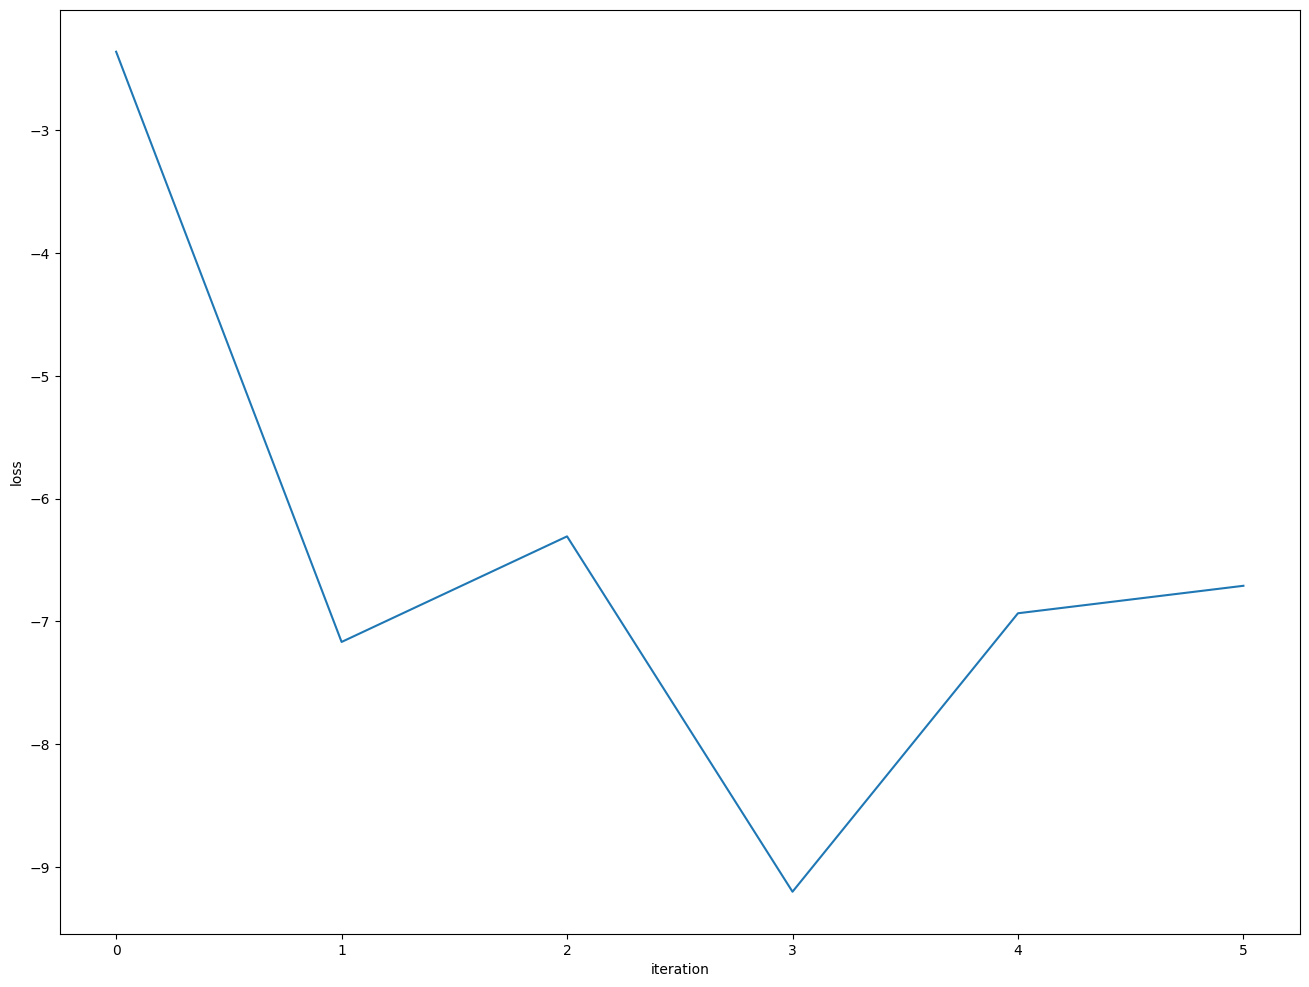

In [55]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

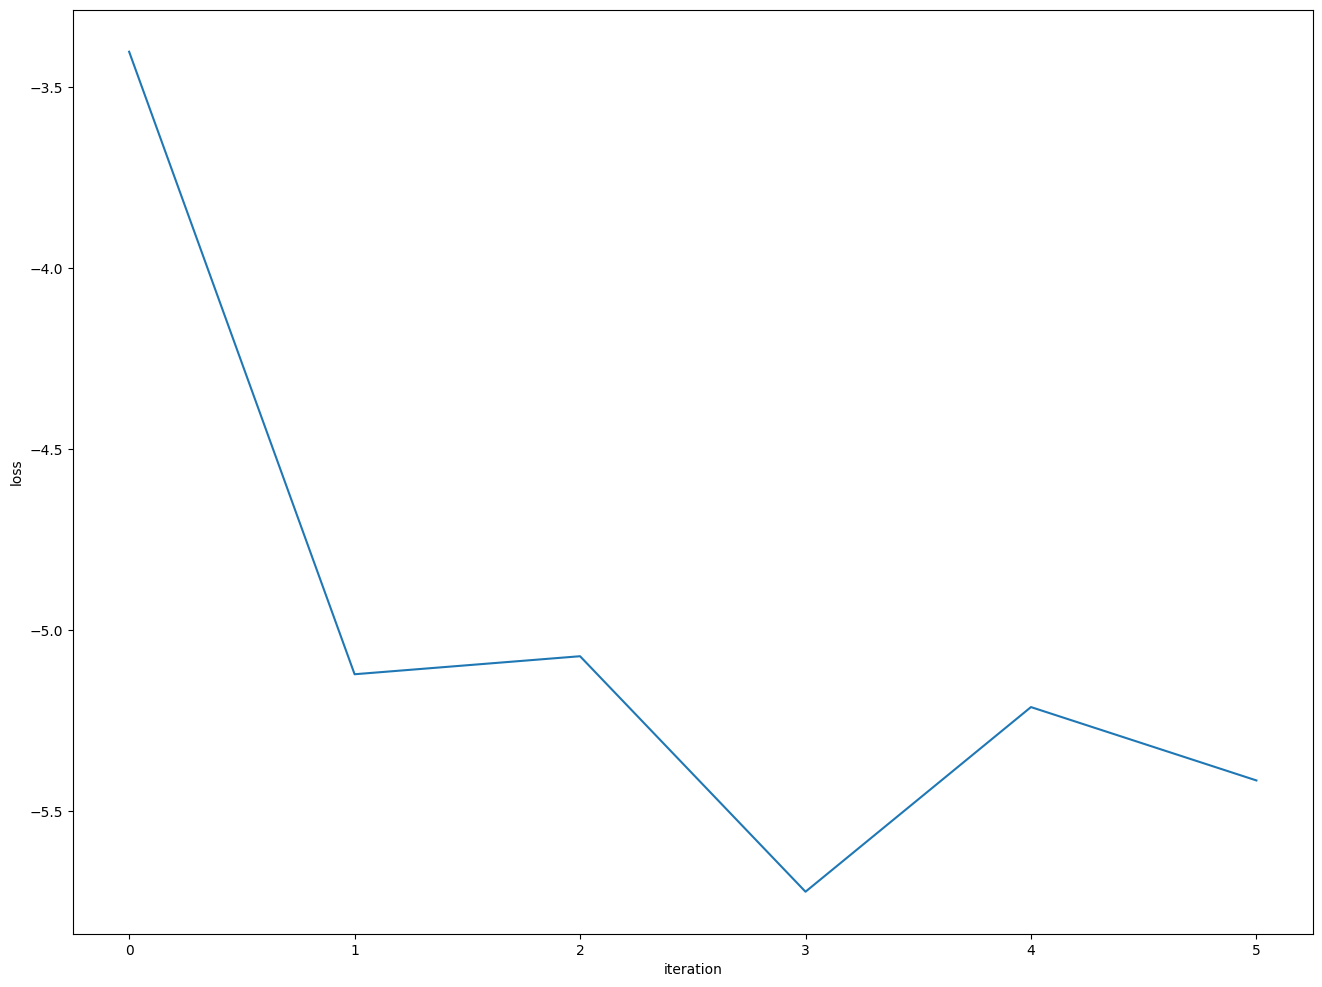

In [56]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")